In [1]:
# remove the notebook root logger.\n",
import logging
logger = logging.getLogger()
logger.handlers = []

In [2]:
import pandas as pd

# Hierarchical Forecasting with PyAF

In this document , we give a use case of hierarchcial forecasting wioth PyAF. 

We study the problem of forecasting France wine exportation by wine type (Champagne , Bordeaux, etc), variant (red , white, sparkling etc) and destination country.

A dataset has been built based on French government opendata gratefully provided by the foreign trade ministry. This dataset is available here : https://github.com/antoinecarme/TimeSeriesData/tree/master/Stat_FR_CommExt. 

Please note that the original dataset is generic and contains export data for all foreign trade products to all possible countries with a significant level of detail (cars, crops, living animals , legal weapons , ...).



## Data Overview

The dataset is a collection of 2872 monthly time series overserved on a period ranging from 2012-01-01 to 2016-09-01.

Each time series has 50 rows (some data are missing in 2015 , under investigation) and represents the export of a given type of wine, a given variant to a unique contry.

The time series column name is built by concatenating the three above informations.

To simplify, we will reduce the number of countries to the 10 most signficant (`wine-friendly`) ones. This reduces the number of columns to 176 ;)

In [3]:
import datetime

filename = "https://raw.githubusercontent.com/antoinecarme/TimeSeriesData/master/Stat_FR_CommExt/merged/French_Wine_Export_in_Euros_Some_Countries.csv"

French_Wine_Export_in_Euros_DF = pd.read_csv(filename);

lDateColumn = 'Month';
French_Wine_Export_in_Euros_DF[lDateColumn] = French_Wine_Export_in_Euros_DF[lDateColumn].apply(lambda x : datetime.datetime.strptime(str(x), "%Y-%m-%d"))

French_Wine_Export_in_Euros_DF.head(5)


Month  ALSACE_BLANC_BE  ALSACE_BLANC_CA  ALSACE_BLANC_CH  \
0 2012-01-01          1131852           571940           257116   
1 2012-02-01           857289           585556           187917   
2 2012-03-01          1438501           834142           679281   
3 2012-04-01           986602           866221           523202   
4 2012-05-01           991668          1061702           611369   

   ALSACE_BLANC_CN  ALSACE_BLANC_DE  ALSACE_BLANC_GB  ALSACE_BLANC_HK  \
0           140013           357516           344274            51043   
1            89805           505896           424953            80220   
2           103577           583887           352675           102980   
3           203456           515903           403517            52773   
4            80327           767522           627232            78115   

   ALSACE_BLANC_JP  ALSACE_BLANC_NL       ...        RHÔNE_ROUGE_CA  \
0           329883           624695       ...                800628   
1           239242           899144       ...                795356   
2           394945          1093638       ...                873858   
3           260953           874217       ...               1004028   
4           680323           994697       ...               2098300   

   RHÔNE_ROUGE_CH  RHÔNE_ROUGE_CN  RHÔNE_ROUGE_DE  RHÔNE_ROUGE_GB  \
0          650236         1127393          783952         1513332   
1          680567          188827          868576         1277664   
2         1318538          856382          627236         2343448   
3          919493          460815          829432         1861188   
4          632778          239200          934532         2215922   

   RHÔNE_ROUGE_HK  RHÔNE_ROUGE_JP  RHÔNE_ROUGE_NL  RHÔNE_ROUGE_OTHER  \
0          335710          916965          314654              35418   
1          197072          318522          516140              36604   
2          132200          605914          410308              43197   
3          128164          472522          290407              45396   
4          202210          337894          284868              41469   

   RHÔNE_ROUGE_US  
0         1260510  
1         2136484  
2         3264810  
3         2631466  
4         2945175  

[5 rows x 177 columns]

In [4]:
French_Wine_Export_in_Euros_DF.describe()

ALSACE_BLANC_BE  ALSACE_BLANC_CA  ALSACE_BLANC_CH  ALSACE_BLANC_CN  \
count     5.000000e+01     5.000000e+01        50.000000        50.000000   
mean      1.189956e+06     8.037735e+05    428923.380000    119348.360000   
std       2.780384e+05     1.691507e+05    158179.648178     65116.609016   
min       5.477480e+05     3.514620e+05     88329.000000     19546.000000   
25%       1.004816e+06     6.791068e+05    316753.500000     82278.500000   
50%       1.161726e+06     8.070940e+05    445554.500000     98656.000000   
75%       1.323582e+06     8.880218e+05    542924.000000    161694.000000   
max       2.166585e+06     1.216720e+06    857207.000000    317661.000000   

       ALSACE_BLANC_DE  ALSACE_BLANC_GB  ALSACE_BLANC_HK  ALSACE_BLANC_JP  \
count     5.000000e+01        50.000000        50.000000        50.000000   
mean      6.173951e+05    414037.100000     88636.820000    361437.900000   
std       2.765474e+05    116398.158498     68347.582681    110140.042643   
min       3.131500e+05    168388.000000     31864.000000    192553.000000   
25%       4.801042e+05    333264.500000     52845.750000    293690.250000   
50%       5.449660e+05    401774.500000     76561.500000    335180.000000   
75%       6.549058e+05    515408.000000    102011.750000    417475.000000   
max       1.871515e+06    635447.000000    510151.000000    680323.000000   

       ALSACE_BLANC_NL  ALSACE_BLANC_OTHER       ...        RHÔNE_ROUGE_CA  \
count     5.000000e+01           50.000000       ...          5.000000e+01   
mean      8.035454e+05        38337.801569       ...          1.607702e+06   
std       2.732401e+05         6088.988573       ...          7.064099e+05   
min       3.085880e+05        18550.156250       ...          7.935600e+05   
25%       6.061862e+05        35457.417067       ...          1.047350e+06   
50%       7.884350e+05        38715.394123       ...          1.506712e+06   
75%       8.980862e+05        41900.001008       ...          1.936743e+06   
max       1.458234e+06        52823.280702       ...          3.946934e+06   

       RHÔNE_ROUGE_CH  RHÔNE_ROUGE_CN  RHÔNE_ROUGE_DE  RHÔNE_ROUGE_GB  \
count    5.000000e+01    5.000000e+01    5.000000e+01    5.000000e+01   
mean     8.523710e+05    7.498312e+05    1.072562e+06    2.876061e+06   
std      2.458533e+05    3.592653e+05    4.307817e+05    1.366642e+06   
min      3.992940e+05    1.888270e+05    5.558550e+05    1.277664e+06   
25%      6.819278e+05    5.089532e+05    7.219495e+05    2.025437e+06   
50%      8.120535e+05    7.065070e+05    9.246160e+05    2.519672e+06   
75%      1.023269e+06    9.285735e+05    1.207832e+06    3.018630e+06   
max      1.334550e+06    1.755449e+06    2.312776e+06    8.652432e+06   

       RHÔNE_ROUGE_HK  RHÔNE_ROUGE_JP  RHÔNE_ROUGE_NL  RHÔNE_ROUGE_OTHER  \
count       50.000000    5.000000e+01    5.000000e+01          50.000000   
mean    235678.640000    5.760031e+05    4.986103e+05       52907.080000   
std     140071.773582    2.398091e+05    1.720202e+05        9667.885799   
min      77550.000000    2.053840e+05    2.311020e+05       35238.000000   
25%     152307.750000    3.751060e+05    3.725818e+05       46721.000000   
50%     203395.000000    5.414685e+05    4.674045e+05       52305.000000   
75%     257873.500000    7.998980e+05    6.143272e+05       59756.250000   
max     879037.000000    1.076535e+06    1.063568e+06       71487.000000   

       RHÔNE_ROUGE_US  
count    5.000000e+01  
mean     2.912355e+06  
std      6.675896e+05  
min      1.260510e+06  
25%      2.500847e+06  
50%      2.896628e+06  
75%      3.380802e+06  
max      4.664273e+06  

[8 rows x 176 columns]

To give an example, the following plot compares the export of Champagne to Germany, Japan and UK:  

In [5]:
%matplotlib inline

/home/antoine/.local/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


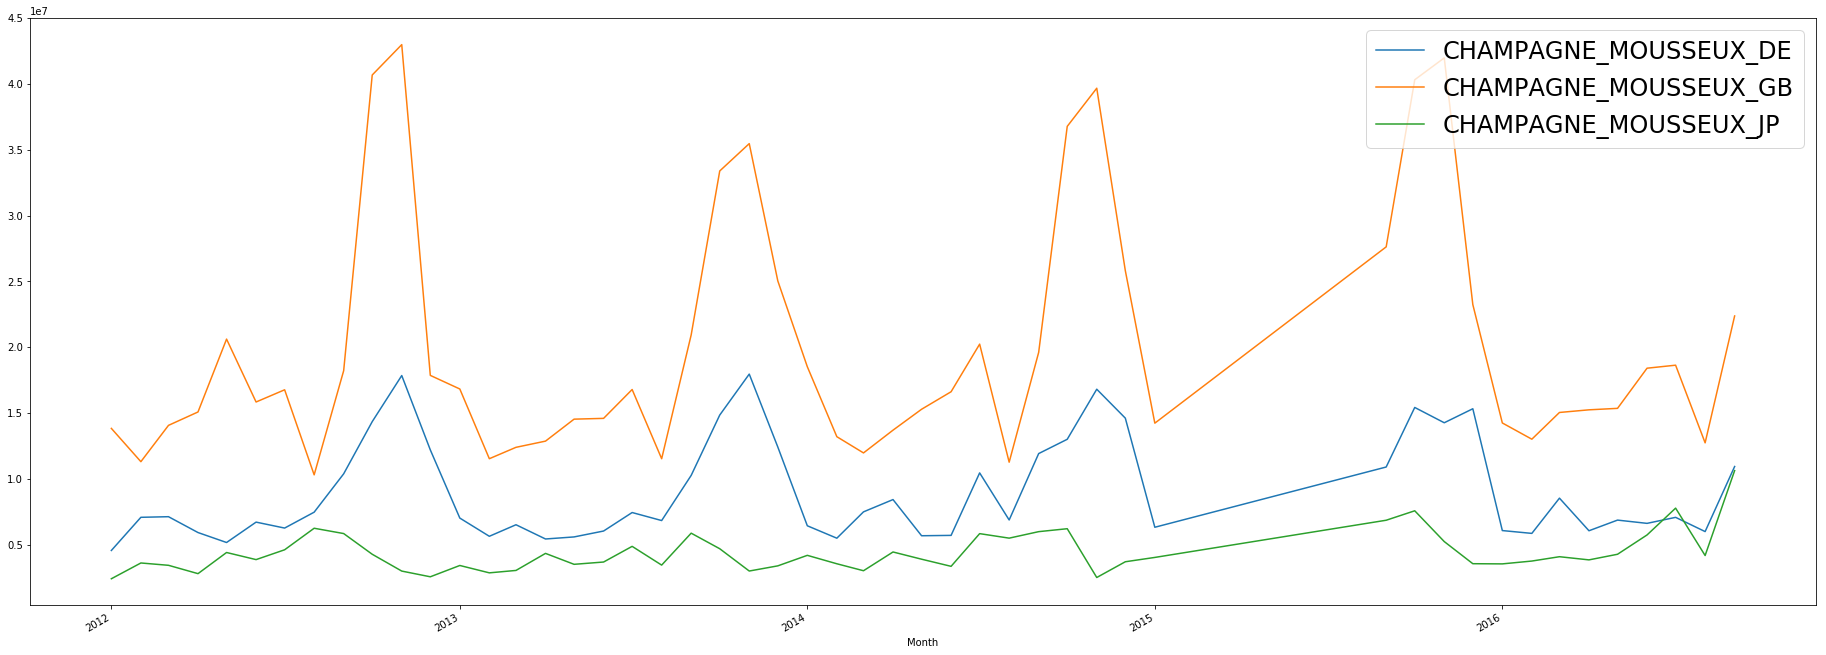

In [6]:
French_Wine_Export_in_Euros_DF.plot('Month' , 
                                    ['CHAMPAGNE_MOUSSEUX_DE', 'CHAMPAGNE_MOUSSEUX_GB' , 'CHAMPAGNE_MOUSSEUX_JP'],
                                   figsize=(32 , 12)).legend(loc='best', fontsize=24)

While the next one compares US consumption (in Euros) of red and white Bordeaux ;)

/home/antoine/.local/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


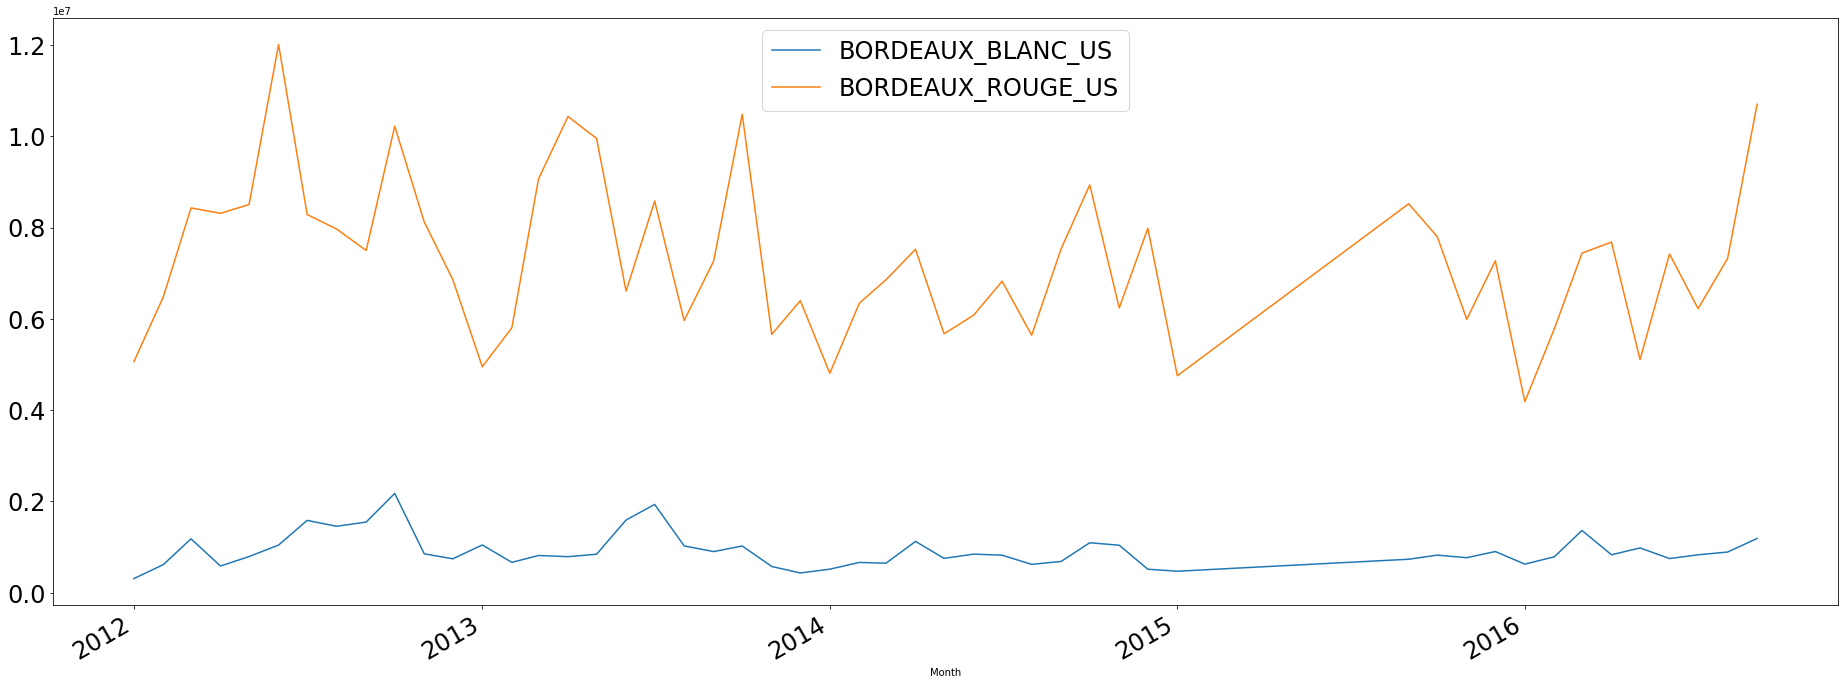

In [7]:
French_Wine_Export_in_Euros_DF.plot('Month' , 
                                    ['BORDEAUX_BLANC_US', 'BORDEAUX_ROUGE_US'],
                                    fontsize = 24,
                                    figsize=(32 , 12)).legend(loc='best', fontsize=24)

In [8]:
CN_columns = [col for col in French_Wine_Export_in_Euros_DF.columns if col.endswith('_CN') ]
French_Wine_Export_in_Euros_DF[CN_columns].describe()


ALSACE_BLANC_CN  BEAUJOLAIS_ROUGE_CN  BORDEAUX_BLANC_CN  \
count        50.000000             50.00000       5.000000e+01   
mean     119348.360000         130292.47000       4.993186e+05   
std       65116.609016         102214.45714       2.936971e+05   
min       19546.000000           5833.00000       1.678740e+05   
25%       82278.500000          66206.50000       3.117738e+05   
50%       98656.000000          98427.50000       4.148980e+05   
75%      161694.000000         158673.75000       5.623658e+05   
max      317661.000000         453985.00000       1.890312e+06   

       BORDEAUX_ROUGE_CN  BOURGOGNE_BLANC_CN  BOURGOGNE_ROUGE_CN  \
count       5.000000e+01           50.000000        5.000000e+01   
mean        1.138432e+07       242575.340000        7.436432e+05   
std         3.081051e+06        99492.736867        4.176045e+05   
min         5.377235e+06        75396.000000        2.725460e+05   
25%         9.737536e+06       171633.250000        4.214805e+05   
50%         1.039686e+07       237099.500000        6.060540e+05   
75%         1.316721e+07       308119.750000        9.648268e+05   
max         1.905088e+07       535157.000000        2.021852e+06   

       CHAMPAGNE_MOUSSEUX_CN  EUROPE_ROUGE_CN  FRANCE_BLANC_CN  \
count           5.000000e+01     5.000000e+01        50.000000   
mean            6.225160e+05     8.313372e+05     12978.062000   
std             3.812781e+05     2.337996e+05     24705.479992   
min             1.976760e+05     3.270090e+05         0.000000   
25%             3.897600e+05     6.529608e+05      1607.250000   
50%             5.299100e+05     8.078685e+05      6237.750000   
75%             7.029695e+05     9.859902e+05     14842.000000   
max             2.103130e+06     1.367882e+06    163701.000000   

       FRANCE_MOUSSEUX_CN  FRANCE_ROUGE_CN  LANGUEDOC_ROUGE_CN  \
count           50.000000        50.000000        5.000000e+01   
mean         93298.256667     11185.281403        1.304245e+06   
std          63521.773261     13888.069451        6.352887e+05   
min          20488.500000       260.500000        4.916860e+05   
25%          46355.750000      4759.017857        9.207640e+05   
50%          82644.583333      8837.333333        1.211934e+06   
75%         118693.250000     12869.584821        1.416010e+06   
max         366064.500000     96564.222222        3.607517e+06   

       LOIRE_BLANC_CN  LOIRE_ROUGE_CN  OTHER_ROUGE_CN  RHÔNE_ROUGE_CN  
count       50.000000       50.000000       50.000000    5.000000e+01  
mean     48771.330000    92016.740000    52969.948000    7.498312e+05  
std      27922.200988    54704.609614    36129.014739    3.592653e+05  
min      16643.500000    15325.000000     6337.750000    1.888270e+05  
25%      31191.250000    54588.250000    28779.650000    5.089532e+05  
50%      37845.750000    77491.500000    44118.875000    7.065070e+05  
75%      62140.375000   119915.500000    62176.000000    9.285735e+05  
max     151128.000000   272948.000000   179114.750000    1.755449e+06

/home/antoine/.local/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


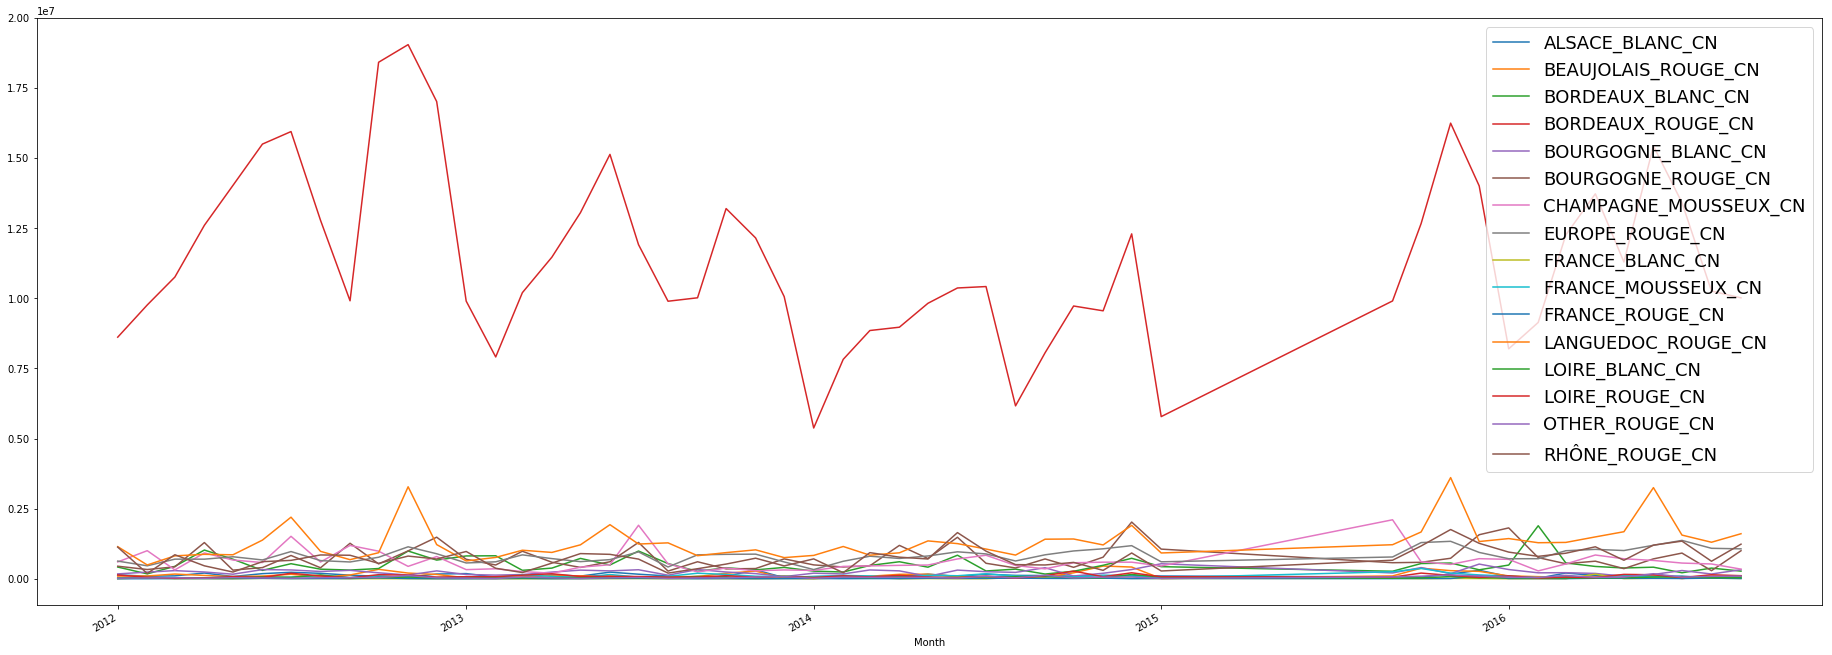

In [9]:
French_Wine_Export_in_Euros_DF.plot('Month' , 
                                    CN_columns,
                                   figsize=(32 , 12)).legend(fontsize=18)

In [10]:
Wines = "ALSACE BEAUJOLAIS BORDEAUX BOURGOGNE CHAMPAGNE EUROPE FRANCE LANGUEDOC LOIRE OTHER RHÔNE".split();
Variants = ['BLANC' , 'MOUSSEUX' , 'ROUGE'];
Countries = ['GB', 'US', 'DE', 'BE', 'CN', 'JP', 'CH', 'HK', 'NL', 'CA' , 'OTHER']



In [11]:
# A lot of possibilities , but only 176 are available ;)
len(Wines) * len(Variants) * len(Countries) 

363

In [12]:
from IPython.display import display


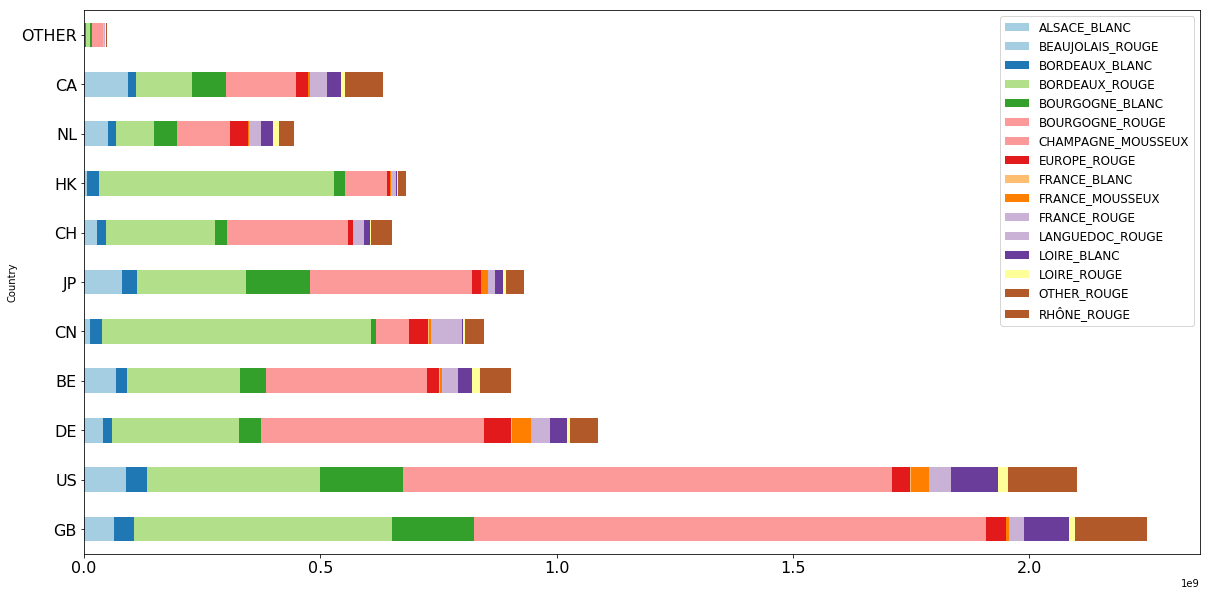

In [13]:
rows = [];
cols = []
for cntry in Countries:
    cntry_columns = [col for col in French_Wine_Export_in_Euros_DF.columns if col.endswith('_' + cntry) ]
    cols = []
    row = [cntry];
    for col in cntry_columns:
        col1 = col.replace('_' + cntry , "")
        sum1 = French_Wine_Export_in_Euros_DF[col].sum()
        row.append(sum1);
        cols.append(col1);
    rows.append(row);

plot_df = pd.DataFrame(rows , columns=['Country'] + cols);

    
plot_df.set_index('Country').plot.barh(stacked=True, figsize=(20,10), fontsize = 16, colormap='Paired').legend(loc='best', fontsize=12)

## Hierarchy Definition


Here, we start by defining as hierarchical to forecast wolrdwide wine export by forecasting country and continent exports.

A country export is computed by afgregating all wine types and variants exported to that country.

In this section, we describe the definition of the hierarchy. 
Again, for clarity, we restrict our work to some countries and some wine types and variants.


In [14]:

Regions = ['EUROPE', 'AMERICA', 'EUROPE' , 'EUROPE' , 'ASIA' , 'ASIA' , 'EUROPE',  'ASIA', 'EUROPE' , 'AMERICA' , 'OTHER_REGION']
lDict = dict(zip(Countries , Regions));

# simplify !!!!
Variants = ['BLANC' , 'ROUGE'];
Wines = Wines[0:3];
Countries = Countries[0:5]

In [15]:
# Hierarchy defintion
rows_list = [];
for v in Variants:
    for w in Wines:
        for c in Countries:
            col = w + "_" + v + "_" + c;
            region = lDict[c]
            if(col in French_Wine_Export_in_Euros_DF.columns):
                rows_list.append([col , c , region , 'WORLD']);
            
lLevels = ['Wine' , 'Country' , 'Region' , 'WORLD'];
lHierarchy = {};
lHierarchy['Levels'] = lLevels;
lHierarchy['Data'] = pd.DataFrame(rows_list, columns =  lLevels);
lHierarchy['Type'] = "Hierarchical";

The hierarchy has been specified this way :

In [16]:
lHierarchy

{'Data':                    Wine Country   Region  WORLD
 0       ALSACE_BLANC_GB      GB   EUROPE  WORLD
 1       ALSACE_BLANC_US      US  AMERICA  WORLD
 2       ALSACE_BLANC_DE      DE   EUROPE  WORLD
 3       ALSACE_BLANC_BE      BE   EUROPE  WORLD
 4       ALSACE_BLANC_CN      CN     ASIA  WORLD
 5     BORDEAUX_BLANC_GB      GB   EUROPE  WORLD
 6     BORDEAUX_BLANC_US      US  AMERICA  WORLD
 7     BORDEAUX_BLANC_DE      DE   EUROPE  WORLD
 8     BORDEAUX_BLANC_BE      BE   EUROPE  WORLD
 9     BORDEAUX_BLANC_CN      CN     ASIA  WORLD
 10  BEAUJOLAIS_ROUGE_GB      GB   EUROPE  WORLD
 11  BEAUJOLAIS_ROUGE_US      US  AMERICA  WORLD
 12  BEAUJOLAIS_ROUGE_DE      DE   EUROPE  WORLD
 13  BEAUJOLAIS_ROUGE_BE      BE   EUROPE  WORLD
 14  BEAUJOLAIS_ROUGE_CN      CN     ASIA  WORLD
 15    BORDEAUX_ROUGE_GB      GB   EUROPE  WORLD
 16    BORDEAUX_ROUGE_US      US  AMERICA  WORLD
 17    BORDEAUX_ROUGE_DE      DE   EUROPE  WORLD
 18    BORDEAUX_ROUGE_BE      BE   EUROPE  WORLD
 19    BORDE

We plot the hierarchy ...


INFO:pyaf.std:START_HIERARCHICAL_PLOTTING


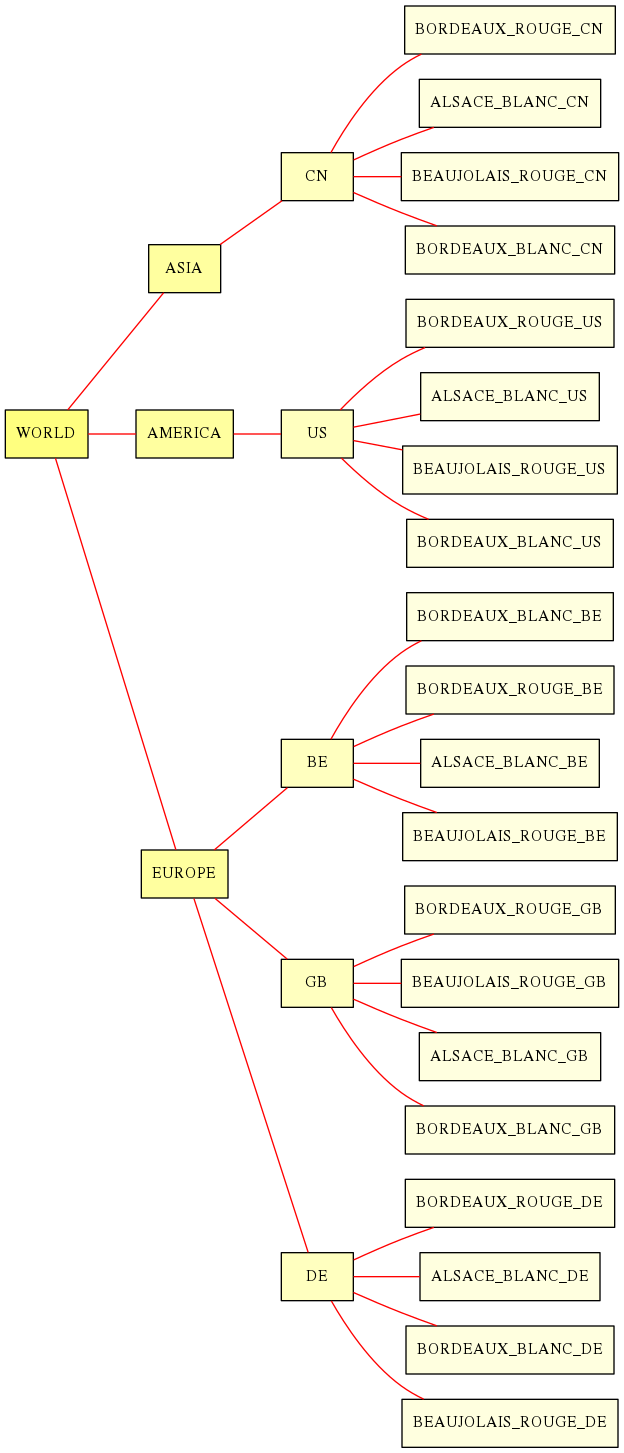

INFO:pyaf.std:END_HIERARCHICAL_PLOTTING_TIME_IN_SECONDS 0.32754945755004883


In [17]:
# create a model to plot the hierarchy.
import pyaf.HierarchicalForecastEngine as hautof
lEngine = hautof.cHierarchicalForecastEngine()


lSignalHierarchy = lEngine.plot_Hierarchy(French_Wine_Export_in_Euros_DF , "Month", "Signal", 1, 
                                          lHierarchy, None);

The strcuture levels have been built :

In [18]:
lSignalHierarchy.mStructure

{0: {'ALSACE_BLANC_BE': set(),
  'ALSACE_BLANC_CN': set(),
  'ALSACE_BLANC_DE': set(),
  'ALSACE_BLANC_GB': set(),
  'ALSACE_BLANC_US': set(),
  'BEAUJOLAIS_ROUGE_BE': set(),
  'BEAUJOLAIS_ROUGE_CN': set(),
  'BEAUJOLAIS_ROUGE_DE': set(),
  'BEAUJOLAIS_ROUGE_GB': set(),
  'BEAUJOLAIS_ROUGE_US': set(),
  'BORDEAUX_BLANC_BE': set(),
  'BORDEAUX_BLANC_CN': set(),
  'BORDEAUX_BLANC_DE': set(),
  'BORDEAUX_BLANC_GB': set(),
  'BORDEAUX_BLANC_US': set(),
  'BORDEAUX_ROUGE_BE': set(),
  'BORDEAUX_ROUGE_CN': set(),
  'BORDEAUX_ROUGE_DE': set(),
  'BORDEAUX_ROUGE_GB': set(),
  'BORDEAUX_ROUGE_US': set()},
 1: {'BE': {'ALSACE_BLANC_BE',
   'BEAUJOLAIS_ROUGE_BE',
   'BORDEAUX_BLANC_BE',
   'BORDEAUX_ROUGE_BE'},
  'CN': {'ALSACE_BLANC_CN',
   'BEAUJOLAIS_ROUGE_CN',
   'BORDEAUX_BLANC_CN',
   'BORDEAUX_ROUGE_CN'},
  'DE': {'ALSACE_BLANC_DE',
   'BEAUJOLAIS_ROUGE_DE',
   'BORDEAUX_BLANC_DE',
   'BORDEAUX_ROUGE_DE'},
  'GB': {'ALSACE_BLANC_GB',
   'BEAUJOLAIS_ROUGE_GB',
   'BORDEAUX_BLANC_GB',
   'BO

## Hierarchical Modelling

Here, we build a first model on the previous hierarchy. Thsi will build an internal model for each node of the previous graph.

Note that the lower (most detailed) level data are coming from the datset and higher levels are obtained by aggregating previous levels.  

We discard the last 4 months of the dataset and try to forecast their values. 

In [19]:
# create a hierarchical model and train it
import pyaf.HierarchicalForecastEngine as hautof

lEngine = hautof.cHierarchicalForecastEngine()

lSignalVar = "Sales";

#
N = French_Wine_Export_in_Euros_DF.shape[0];
H = 4;
train_df = French_Wine_Export_in_Euros_DF.head(N-H);


lSignalHierarchy = lEngine.train(train_df , lDateColumn, lSignalVar, 1, lHierarchy, None);

INFO:pyaf.std:START_HIERARCHICAL_TRAINING
INFO:pyaf.hierarchical:TRAINING_MODEL_LEVEL_SIGNAL 0 ALSACE_BLANC_BE
INFO:pyaf.std:START_TRAINING 'ALSACE_BLANC_BE'
INFO:pyaf.std:END_TRAINING_TIME_IN_SECONDS 'ALSACE_BLANC_BE' 1.5299549102783203
INFO:pyaf.std:TIME_DETAIL TimeVariable='Month' TimeMin=2012-01-01T00:00:00.000000 TimeMax=2014-12-01T00:00:00.000000 TimeDelta=30 days Estimation = (0 , 36) Validation = (36 , 45) Test = (45 , 46) Horizon=1
INFO:pyaf.std:SIGNAL_DETAIL SignalVariable='_ALSACE_BLANC_BE' Min=547748 Max=2166585  Mean=1210707.78261 StdDev=275212.588648
INFO:pyaf.std:BEST_TRANSOFORMATION_TYPE '_'
INFO:pyaf.std:BEST_DECOMPOSITION  '_ALSACE_BLANC_BE_ConstantTrend_residue_zeroCycle_residue_NoAR' [ConstantTrend + NoCycle + NoAR]
INFO:pyaf.std:TREND_DETAIL '_ALSACE_BLANC_BE_ConstantTrend' [ConstantTrend]
INFO:pyaf.std:CYCLE_DETAIL '_ALSACE_BLANC_BE_ConstantTrend_residue_zeroCycle' [NoCycle]
INFO:pyaf.std:AUTOREG_DETAIL '_ALSACE_BLANC_BE_ConstantTrend_residue_zeroCycle_residue_NoA

INFO:pyaf.std:MODEL_L2 L2_Fit=165735.856941 L2_Forecast=178019.572184 L2_Test=86027.7504414
INFO:pyaf.std:MODEL_COMPLEXITY 11
INFO:pyaf.std:AR_MODEL_DETAIL_START
INFO:pyaf.std:AR_MODEL_COEFF 1 _ALSACE_BLANC_US_ConstantTrend_residue_zeroCycle_residue_Lag6 -0.392168345626
INFO:pyaf.std:AR_MODEL_COEFF 2 _ALSACE_BLANC_US_ConstantTrend_residue_zeroCycle_residue_Lag7 0.222456423248
INFO:pyaf.std:AR_MODEL_COEFF 3 _ALSACE_BLANC_US_ConstantTrend_residue_zeroCycle_residue_Lag11 0.210277136082
INFO:pyaf.std:AR_MODEL_COEFF 4 _ALSACE_BLANC_US_ConstantTrend_residue_zeroCycle_residue_Lag1 0.197001480779
INFO:pyaf.std:AR_MODEL_COEFF 5 _ALSACE_BLANC_US_ConstantTrend_residue_zeroCycle_residue_Lag8 -0.161909167071
INFO:pyaf.std:AR_MODEL_COEFF 6 _ALSACE_BLANC_US_ConstantTrend_residue_zeroCycle_residue_Lag5 0.139807425168
INFO:pyaf.std:AR_MODEL_COEFF 7 _ALSACE_BLANC_US_ConstantTrend_residue_zeroCycle_residue_Lag10 -0.12616649198
INFO:pyaf.std:AR_MODEL_COEFF 8 _ALSACE_BLANC_US_ConstantTrend_residue_zeroCycl

INFO:pyaf.std:MODEL_MAPE MAPE_Fit=0.5762 MAPE_Forecast=0.2867 MAPE_Test=0.2685
INFO:pyaf.std:MODEL_SMAPE SMAPE_Fit=0.4781 SMAPE_Forecast=0.2956 SMAPE_Test=0.2367
INFO:pyaf.std:MODEL_MASE MASE_Fit=0.8072 MASE_Forecast=0.5783 MASE_Test=None
INFO:pyaf.std:MODEL_L1 L1_Fit=582255.071752 L1_Forecast=387408.120254 L1_Test=163654.828984
INFO:pyaf.std:MODEL_L2 L2_Fit=867034.396089 L2_Forecast=774435.601347 L2_Test=163654.828984
INFO:pyaf.std:MODEL_COMPLEXITY 16
INFO:pyaf.std:AR_MODEL_DETAIL_START
INFO:pyaf.std:AR_MODEL_DETAIL_END
INFO:pyaf.hierarchical:TRAINING_MODEL_LEVEL_SIGNAL 0 BORDEAUX_BLANC_BE
INFO:pyaf.std:START_TRAINING 'BORDEAUX_BLANC_BE'
INFO:pyaf.std:END_TRAINING_TIME_IN_SECONDS 'BORDEAUX_BLANC_BE' 1.305854320526123
INFO:pyaf.std:TIME_DETAIL TimeVariable='Month' TimeMin=2012-01-01T00:00:00.000000 TimeMax=2014-12-01T00:00:00.000000 TimeDelta=30 days Estimation = (0 , 36) Validation = (36 , 45) Test = (45 , 46) Horizon=1
INFO:pyaf.std:SIGNAL_DETAIL SignalVariable='_BORDEAUX_BLANC_BE' M

INFO:pyaf.std:AR_MODEL_COEFF 9 _BORDEAUX_BLANC_GB_Lag1Trend_residue_zeroCycle_residue_Lag4 -0.071557574934
INFO:pyaf.std:AR_MODEL_DETAIL_END
INFO:pyaf.hierarchical:TRAINING_MODEL_LEVEL_SIGNAL 0 BORDEAUX_BLANC_US
INFO:pyaf.std:START_TRAINING 'BORDEAUX_BLANC_US'
INFO:pyaf.std:END_TRAINING_TIME_IN_SECONDS 'BORDEAUX_BLANC_US' 1.3051207065582275
INFO:pyaf.std:TIME_DETAIL TimeVariable='Month' TimeMin=2012-01-01T00:00:00.000000 TimeMax=2014-12-01T00:00:00.000000 TimeDelta=30 days Estimation = (0 , 36) Validation = (36 , 45) Test = (45 , 46) Horizon=1
INFO:pyaf.std:SIGNAL_DETAIL SignalVariable='_BORDEAUX_BLANC_US' Min=308516 Max=2175193  Mean=915953.869565 StdDev=381971.958726
INFO:pyaf.std:BEST_TRANSOFORMATION_TYPE '_'
INFO:pyaf.std:BEST_DECOMPOSITION  '_BORDEAUX_BLANC_US_LinearTrend_residue_zeroCycle_residue_NoAR' [LinearTrend + NoCycle + NoAR]
INFO:pyaf.std:TREND_DETAIL '_BORDEAUX_BLANC_US_LinearTrend' [LinearTrend]
INFO:pyaf.std:CYCLE_DETAIL '_BORDEAUX_BLANC_US_LinearTrend_residue_zeroCycl

INFO:pyaf.std:MODEL_MAPE MAPE_Fit=0.3547 MAPE_Forecast=0.1592 MAPE_Test=0.1213
INFO:pyaf.std:MODEL_SMAPE SMAPE_Fit=0.3104 SMAPE_Forecast=0.1541 SMAPE_Test=0.1291
INFO:pyaf.std:MODEL_MASE MASE_Fit=0.9722 MASE_Forecast=0.9753 MASE_Test=None
INFO:pyaf.std:MODEL_L1 L1_Fit=3622128.5 L1_Forecast=951526.777778 L1_Test=801509.0
INFO:pyaf.std:MODEL_L2 L2_Fit=4522958.71673 L2_Forecast=1259434.91006 L2_Test=801509.0
INFO:pyaf.std:MODEL_COMPLEXITY 32
INFO:pyaf.std:AR_MODEL_DETAIL_START
INFO:pyaf.std:AR_MODEL_DETAIL_END
INFO:pyaf.hierarchical:TRAINING_MODEL_LEVEL_SIGNAL 0 BORDEAUX_ROUGE_US
INFO:pyaf.std:START_TRAINING 'BORDEAUX_ROUGE_US'
INFO:pyaf.std:END_TRAINING_TIME_IN_SECONDS 'BORDEAUX_ROUGE_US' 1.3268682956695557
INFO:pyaf.std:TIME_DETAIL TimeVariable='Month' TimeMin=2012-01-01T00:00:00.000000 TimeMax=2014-12-01T00:00:00.000000 TimeDelta=30 days Estimation = (0 , 36) Validation = (36 , 45) Test = (45 , 46) Horizon=1
INFO:pyaf.std:SIGNAL_DETAIL SignalVariable='Diff_BORDEAUX_ROUGE_US' Min=-48209

INFO:pyaf.std:TREND_DETAIL '_DE_Lag1Trend' [Lag1Trend]
INFO:pyaf.std:CYCLE_DETAIL '_DE_Lag1Trend_residue_zeroCycle' [NoCycle]
INFO:pyaf.std:AUTOREG_DETAIL '_DE_Lag1Trend_residue_zeroCycle_residue_NoAR' [NoAR]
INFO:pyaf.std:MODEL_MAPE MAPE_Fit=0.2663 MAPE_Forecast=0.2377 MAPE_Test=0.2269
INFO:pyaf.std:MODEL_SMAPE SMAPE_Fit=0.2562 SMAPE_Forecast=0.2098 SMAPE_Test=0.2037
INFO:pyaf.std:MODEL_MASE MASE_Fit=0.9722 MASE_Forecast=1.0209 MASE_Test=None
INFO:pyaf.std:MODEL_L1 L1_Fit=1780306.33333 L1_Forecast=1107360.88889 L1_Test=868251.0
INFO:pyaf.std:MODEL_L2 L2_Fit=2608066.12821 L2_Forecast=1311702.05848 L2_Test=868251.0
INFO:pyaf.std:MODEL_COMPLEXITY 32
INFO:pyaf.std:AR_MODEL_DETAIL_START
INFO:pyaf.std:AR_MODEL_DETAIL_END
INFO:pyaf.hierarchical:TRAINING_MODEL_LEVEL_SIGNAL 1 GB
INFO:pyaf.std:START_TRAINING 'GB'
INFO:pyaf.std:END_TRAINING_TIME_IN_SECONDS 'GB' 1.3173463344573975
INFO:pyaf.std:TIME_DETAIL TimeVariable='Month' TimeMin=2012-01-01T00:00:00.000000 TimeMax=2014-12-01T00:00:00.000000 

INFO:pyaf.std:MODEL_SMAPE SMAPE_Fit=0.2172 SMAPE_Forecast=0.1413 SMAPE_Test=0.088
INFO:pyaf.std:MODEL_MASE MASE_Fit=0.9985 MASE_Forecast=0.8263 MASE_Test=None
INFO:pyaf.std:MODEL_L1 L1_Fit=6329591.42747 L1_Forecast=2716338.99691 L1_Test=1531726.72222
INFO:pyaf.std:MODEL_L2 L2_Fit=8301515.61194 L2_Forecast=3085512.63086 L2_Test=1531726.72222
INFO:pyaf.std:MODEL_COMPLEXITY 32
INFO:pyaf.std:AR_MODEL_DETAIL_START
INFO:pyaf.std:AR_MODEL_DETAIL_END
INFO:pyaf.hierarchical:TRAINING_MODEL_LEVEL_SIGNAL 3 WORLD
INFO:pyaf.std:START_TRAINING 'WORLD'
INFO:pyaf.std:END_TRAINING_TIME_IN_SECONDS 'WORLD' 1.2960877418518066
INFO:pyaf.std:TIME_DETAIL TimeVariable='Month' TimeMin=2012-01-01T00:00:00.000000 TimeMax=2014-12-01T00:00:00.000000 TimeDelta=30 days Estimation = (0 , 36) Validation = (36 , 45) Test = (45 , 46) Horizon=1
INFO:pyaf.std:SIGNAL_DETAIL SignalVariable='_WORLD' Min=28850872.5 Max=74341125.5  Mean=49180545.1087 StdDev=11452870.2777
INFO:pyaf.std:BEST_TRANSOFORMATION_TYPE '_'
INFO:pyaf.std

INFO:pyaf.std:MODEL_LEVEL (0, ['ALSACE_BLANC_BE', 'ALSACE_BLANC_CN', 'ALSACE_BLANC_DE', 'ALSACE_BLANC_GB', 'ALSACE_BLANC_US', 'BEAUJOLAIS_ROUGE_BE', 'BEAUJOLAIS_ROUGE_CN', 'BEAUJOLAIS_ROUGE_DE', 'BEAUJOLAIS_ROUGE_GB', 'BEAUJOLAIS_ROUGE_US', 'BORDEAUX_BLANC_BE', 'BORDEAUX_BLANC_CN', 'BORDEAUX_BLANC_DE', 'BORDEAUX_BLANC_GB', 'BORDEAUX_BLANC_US', 'BORDEAUX_ROUGE_BE', 'BORDEAUX_ROUGE_CN', 'BORDEAUX_ROUGE_DE', 'BORDEAUX_ROUGE_GB', 'BORDEAUX_ROUGE_US'])
INFO:pyaf.std:STRUCTURE_LEVEL (1, ['BE', 'CN', 'DE', 'GB', 'US'])
INFO:pyaf.std:MODEL_LEVEL (1, ['BE', 'CN', 'DE', 'GB', 'US'])
INFO:pyaf.std:STRUCTURE_LEVEL (2, ['AMERICA', 'ASIA', 'EUROPE'])
INFO:pyaf.std:MODEL_LEVEL (2, ['AMERICA', 'ASIA', 'EUROPE'])
INFO:pyaf.std:STRUCTURE_LEVEL (3, ['WORLD'])
INFO:pyaf.std:MODEL_LEVEL (3, ['WORLD'])
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_FIT_PERF ('ALSACE_BLANC_BE_BU', 199577.56080021942, 0.14180000000000001, 199577.56080021942, 0.14180000000000001)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_VALID_PERF ('A

INFO:pyaf.std:REPORT_COMBINED_FORECASTS_FIT_PERF ('EUROPE_BU', 8301515.6119398801, 0.2054, 6747586.2254487388, 0.21199999999999999)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_VALID_PERF ('EUROPE_BU', 3085512.6308608619, 0.14680000000000001, 2443759.5403470742, 0.1116)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_FIT_PERF ('GB_BU', 5023345.7090325709, 0.3503, 4910323.308976409, 0.3427)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_VALID_PERF ('GB_BU', 1567222.4394758958, 0.15790000000000001, 1555255.9635870806, 0.15140000000000001)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_FIT_PERF ('US_BU', 2510501.2872883952, 0.19170000000000001, 4139444.8981735716, 0.31740000000000002)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_VALID_PERF ('US_BU', 2096609.4319779796, 0.22090000000000001, 1961288.3969814761, 0.2064)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_FIT_PERF ('WORLD_BU', 6571495.0536185373, 0.10730000000000001, 9271518.6862805933, 0.14699999999999999)
INFO:pyaf.std:REPORT_COMBINED_FORECASTS_VALID_PERF ('WORLD_BU'

In [20]:
French_Wine_Export_in_Euros_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Columns: 177 entries, Month to RHÔNE_ROUGE_US
dtypes: datetime64[ns](1), float64(56), int64(120)
memory usage: 69.2 KB


In [21]:
lInfo = lEngine.to_json()
lInfo.keys()

dict_keys(['Structure', 'Models'])

In [22]:
lInfo['Structure']

{0: {'ALSACE_BLANC_BE': set(),
  'ALSACE_BLANC_CN': set(),
  'ALSACE_BLANC_DE': set(),
  'ALSACE_BLANC_GB': set(),
  'ALSACE_BLANC_US': set(),
  'BEAUJOLAIS_ROUGE_BE': set(),
  'BEAUJOLAIS_ROUGE_CN': set(),
  'BEAUJOLAIS_ROUGE_DE': set(),
  'BEAUJOLAIS_ROUGE_GB': set(),
  'BEAUJOLAIS_ROUGE_US': set(),
  'BORDEAUX_BLANC_BE': set(),
  'BORDEAUX_BLANC_CN': set(),
  'BORDEAUX_BLANC_DE': set(),
  'BORDEAUX_BLANC_GB': set(),
  'BORDEAUX_BLANC_US': set(),
  'BORDEAUX_ROUGE_BE': set(),
  'BORDEAUX_ROUGE_CN': set(),
  'BORDEAUX_ROUGE_DE': set(),
  'BORDEAUX_ROUGE_GB': set(),
  'BORDEAUX_ROUGE_US': set()},
 1: {'BE': {'ALSACE_BLANC_BE',
   'BEAUJOLAIS_ROUGE_BE',
   'BORDEAUX_BLANC_BE',
   'BORDEAUX_ROUGE_BE'},
  'CN': {'ALSACE_BLANC_CN',
   'BEAUJOLAIS_ROUGE_CN',
   'BORDEAUX_BLANC_CN',
   'BORDEAUX_ROUGE_CN'},
  'DE': {'ALSACE_BLANC_DE',
   'BEAUJOLAIS_ROUGE_DE',
   'BORDEAUX_BLANC_DE',
   'BORDEAUX_ROUGE_DE'},
  'GB': {'ALSACE_BLANC_GB',
   'BEAUJOLAIS_ROUGE_GB',
   'BORDEAUX_BLANC_GB',
   'BO

In [23]:
lInfo['Models'].keys()

dict_keys(['ALSACE_BLANC_BE', 'ALSACE_BLANC_CN', 'ALSACE_BLANC_DE', 'ALSACE_BLANC_GB', 'ALSACE_BLANC_US', 'BEAUJOLAIS_ROUGE_BE', 'BEAUJOLAIS_ROUGE_CN', 'BEAUJOLAIS_ROUGE_DE', 'BEAUJOLAIS_ROUGE_GB', 'BEAUJOLAIS_ROUGE_US', 'BORDEAUX_BLANC_BE', 'BORDEAUX_BLANC_CN', 'BORDEAUX_BLANC_DE', 'BORDEAUX_BLANC_GB', 'BORDEAUX_BLANC_US', 'BORDEAUX_ROUGE_BE', 'BORDEAUX_ROUGE_CN', 'BORDEAUX_ROUGE_DE', 'BORDEAUX_ROUGE_GB', 'BORDEAUX_ROUGE_US', 'BE', 'CN', 'DE', 'GB', 'US', 'AMERICA', 'ASIA', 'EUROPE', 'WORLD'])

In [24]:
lInfo['Models']['BORDEAUX_ROUGE_CN']

{'Dataset': {'Signal': 'BORDEAUX_ROUGE_CN',
  'Time': {'Horizon': 1,
   'TimeMinMax': ['2012-01-01 00:00:00', '2016-05-01 00:00:00'],
   'TimeVariable': 'Month'},
  'Training_Signal_Length': 46},
 'Model': {'AR_Model': 'AR(11)',
  'Best_Decomposition': 'Diff_BORDEAUX_ROUGE_CN_ConstantTrend_residue_zeroCycle_residue_AR(11)',
  'Cycle': 'NoCycle',
  'Signal_Transoformation': 'Difference',
  'Trend': 'ConstantTrend'},
 'Model_Performance': {'COMPLEXITY': '43',
  'MAE': '2110502.46896',
  'MAPE': '0.2216',
  'MASE': '0.7022',
  'RMSE': '2646130.42323'}}

In [25]:
perfs = [];
for model in sorted(lInfo['Models'].keys()):
    lPerf = lInfo['Models'][model]['Model_Performance']
    perfs.append([model , lPerf['RMSE'] , lPerf['MAPE']])
df_perf = pd.DataFrame(perfs , columns=['Model' , 'RMSE' , 'MAPE']);
df_perf = df_perf.sort_values(by = ['MAPE'])
print(df_perf)

                  Model           RMSE    MAPE
16    BORDEAUX_BLANC_GB  99936.6878925   0.133
28                WORLD  6516614.47132  0.1367
3       ALSACE_BLANC_GB  66480.1666393  0.1402
25               EUROPE  3085512.63086  0.1468
26                   GB  1567222.43948  0.1579
21    BORDEAUX_ROUGE_GB  1259434.91006  0.1592
7                    BE  1150941.46298  0.1693
2       ALSACE_BLANC_DE  144769.492274  0.1906
18    BORDEAUX_ROUGE_BE   921082.27271  0.1915
22    BORDEAUX_ROUGE_US   1279973.4076  0.1988
17    BORDEAUX_BLANC_US  252977.835616  0.2096
5               AMERICA  2096609.43198  0.2209
27                   US  2096609.43198  0.2209
19    BORDEAUX_ROUGE_CN  2646130.42323  0.2216
23                   CN  2852608.78104  0.2353
6                  ASIA  2852608.78104  0.2353
24                   DE  1311702.05848  0.2377
4       ALSACE_BLANC_US  178019.572184   0.238
15    BORDEAUX_BLANC_DE  201387.259056  0.2533
20    BORDEAUX_ROUGE_DE  1186136.69738   0.272
12  BEAUJOLAI

INFO:pyaf.std:START_HIERARCHICAL_PLOTTING


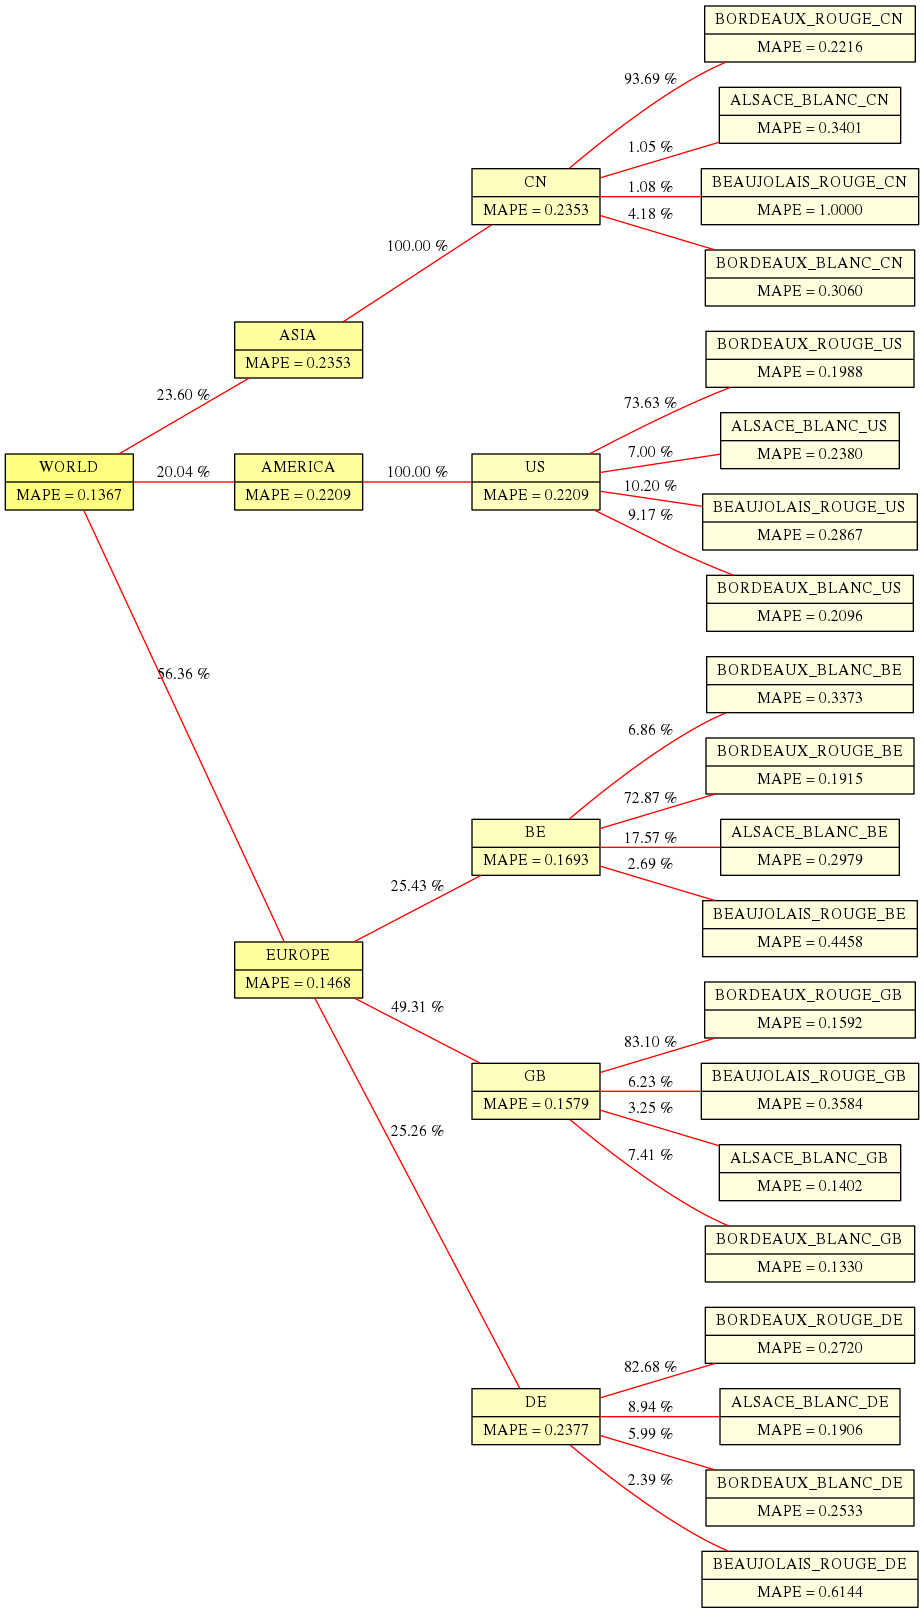

INFO:pyaf.std:END_HIERARCHICAL_PLOTTING_TIME_IN_SECONDS 0.20366382598876953


In [26]:
lEngine.mSignalHierarchy.plot()

In [27]:
BORDEAUX_ROUGE_CN_Engine = lEngine.mSignalHierarchy.mModels[0]['BORDEAUX_ROUGE_CN']

In [28]:
BORDEAUX_ROUGE_CN_Engine.getModelInfo()

INFO:pyaf.std:TIME_DETAIL TimeVariable='Month' TimeMin=2012-01-01T00:00:00.000000 TimeMax=2014-12-01T00:00:00.000000 TimeDelta=30 days Estimation = (0 , 36) Validation = (36 , 45) Test = (45 , 46) Horizon=1
INFO:pyaf.std:SIGNAL_DETAIL SignalVariable='Diff_BORDEAUX_ROUGE_CN' Min=-7118004.0 Max=8508070.0  Mean=58285.3478261 StdDev=2959960.35338
INFO:pyaf.std:BEST_TRANSOFORMATION_TYPE 'Diff_'
INFO:pyaf.std:BEST_DECOMPOSITION  'Diff_BORDEAUX_ROUGE_CN_ConstantTrend_residue_zeroCycle_residue_AR(11)' [ConstantTrend + NoCycle + AR(11)]
INFO:pyaf.std:TREND_DETAIL 'Diff_BORDEAUX_ROUGE_CN_ConstantTrend' [ConstantTrend]
INFO:pyaf.std:CYCLE_DETAIL 'Diff_BORDEAUX_ROUGE_CN_ConstantTrend_residue_zeroCycle' [NoCycle]
INFO:pyaf.std:AUTOREG_DETAIL 'Diff_BORDEAUX_ROUGE_CN_ConstantTrend_residue_zeroCycle_residue_AR(11)' [AR(11)]
INFO:pyaf.std:MODEL_MAPE MAPE_Fit=0.3932 MAPE_Forecast=0.2216 MAPE_Test=0.0703
INFO:pyaf.std:MODEL_SMAPE SMAPE_Fit=0.521 SMAPE_Forecast=0.1932 SMAPE_Test=0.0679
INFO:pyaf.std:MODEL

INFO:pyaf.std:START_PLOTTING
/home/antoine/dev/python/packages/pyaf/TS/Plots.py:31: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/antoine/.local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/anto

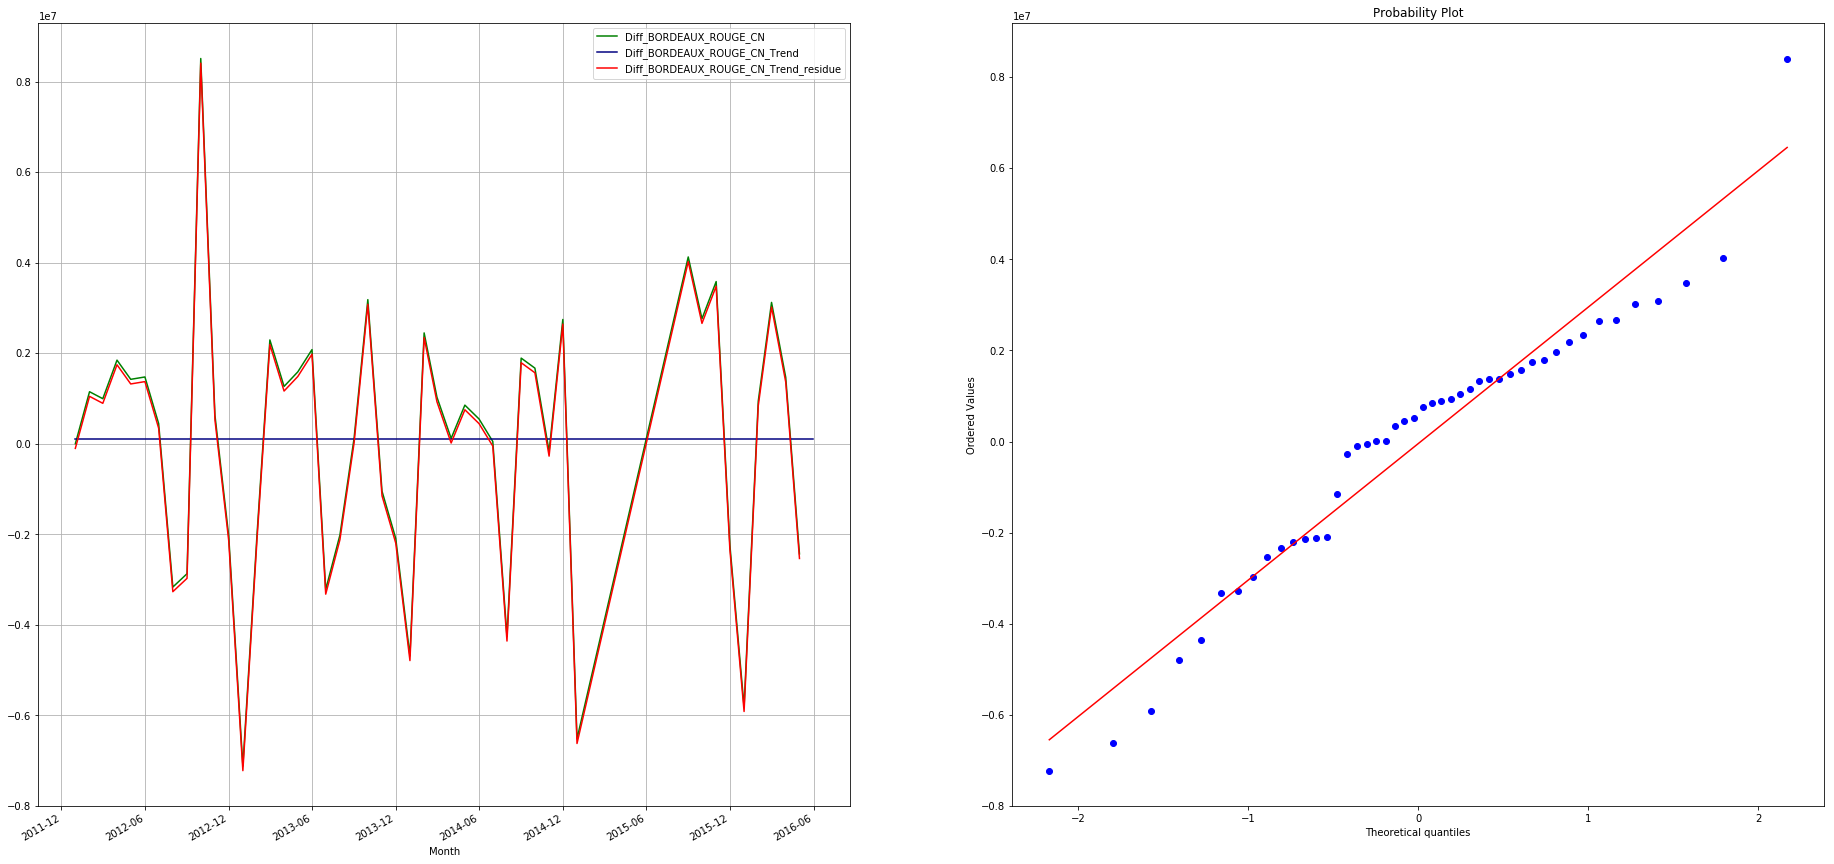

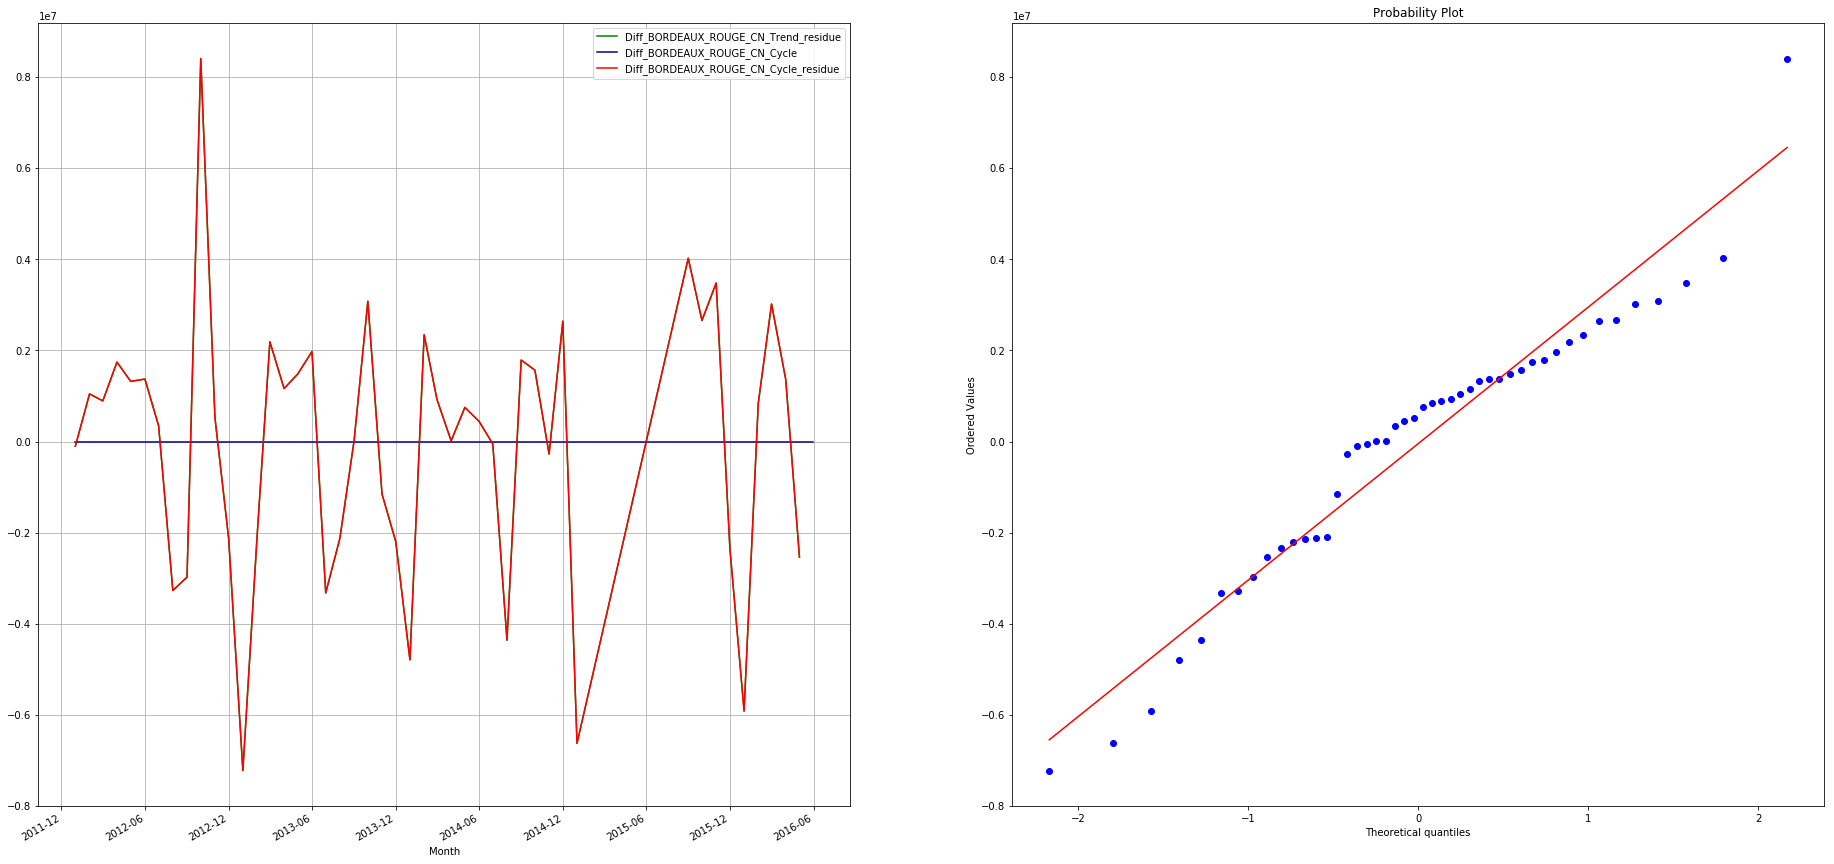

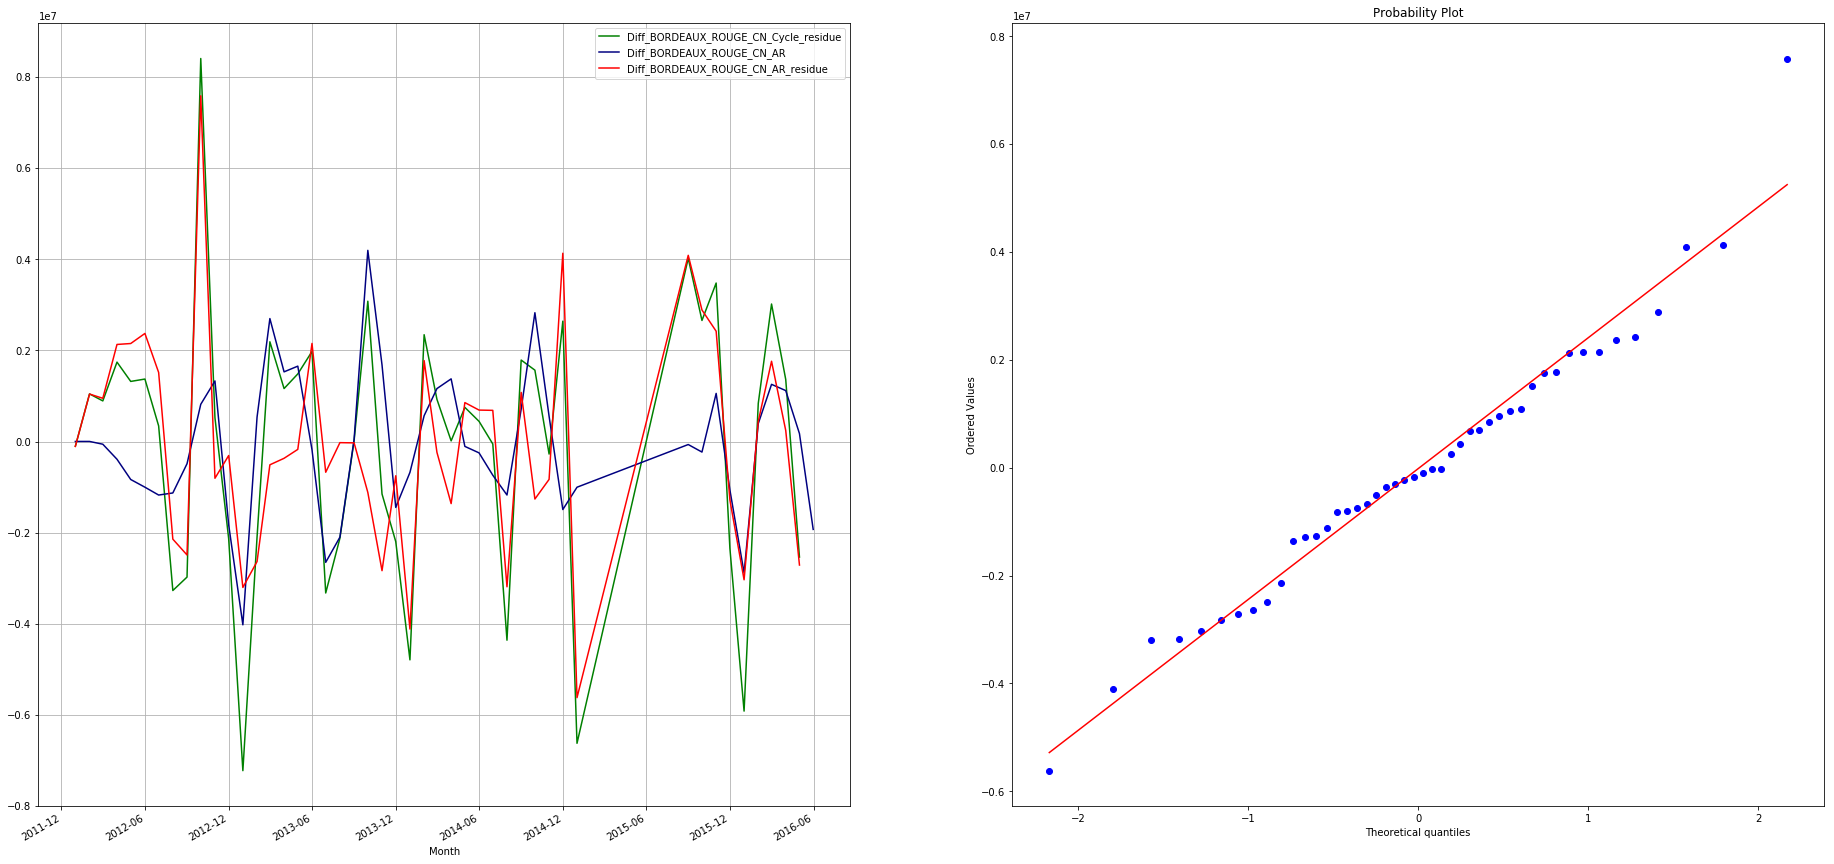

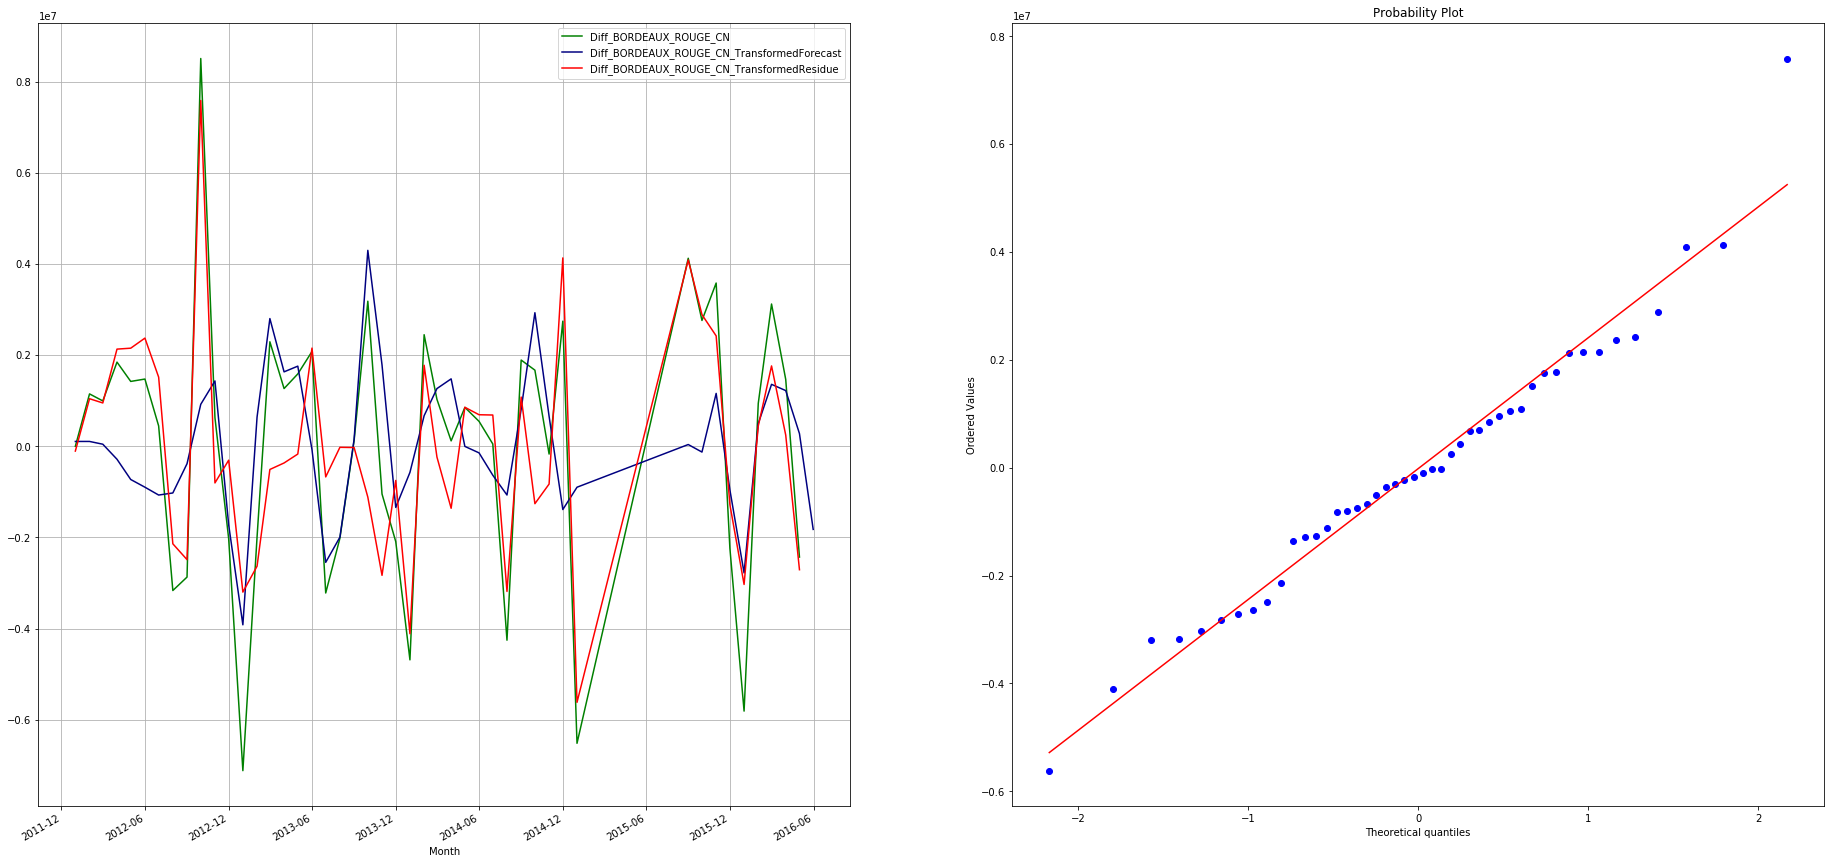

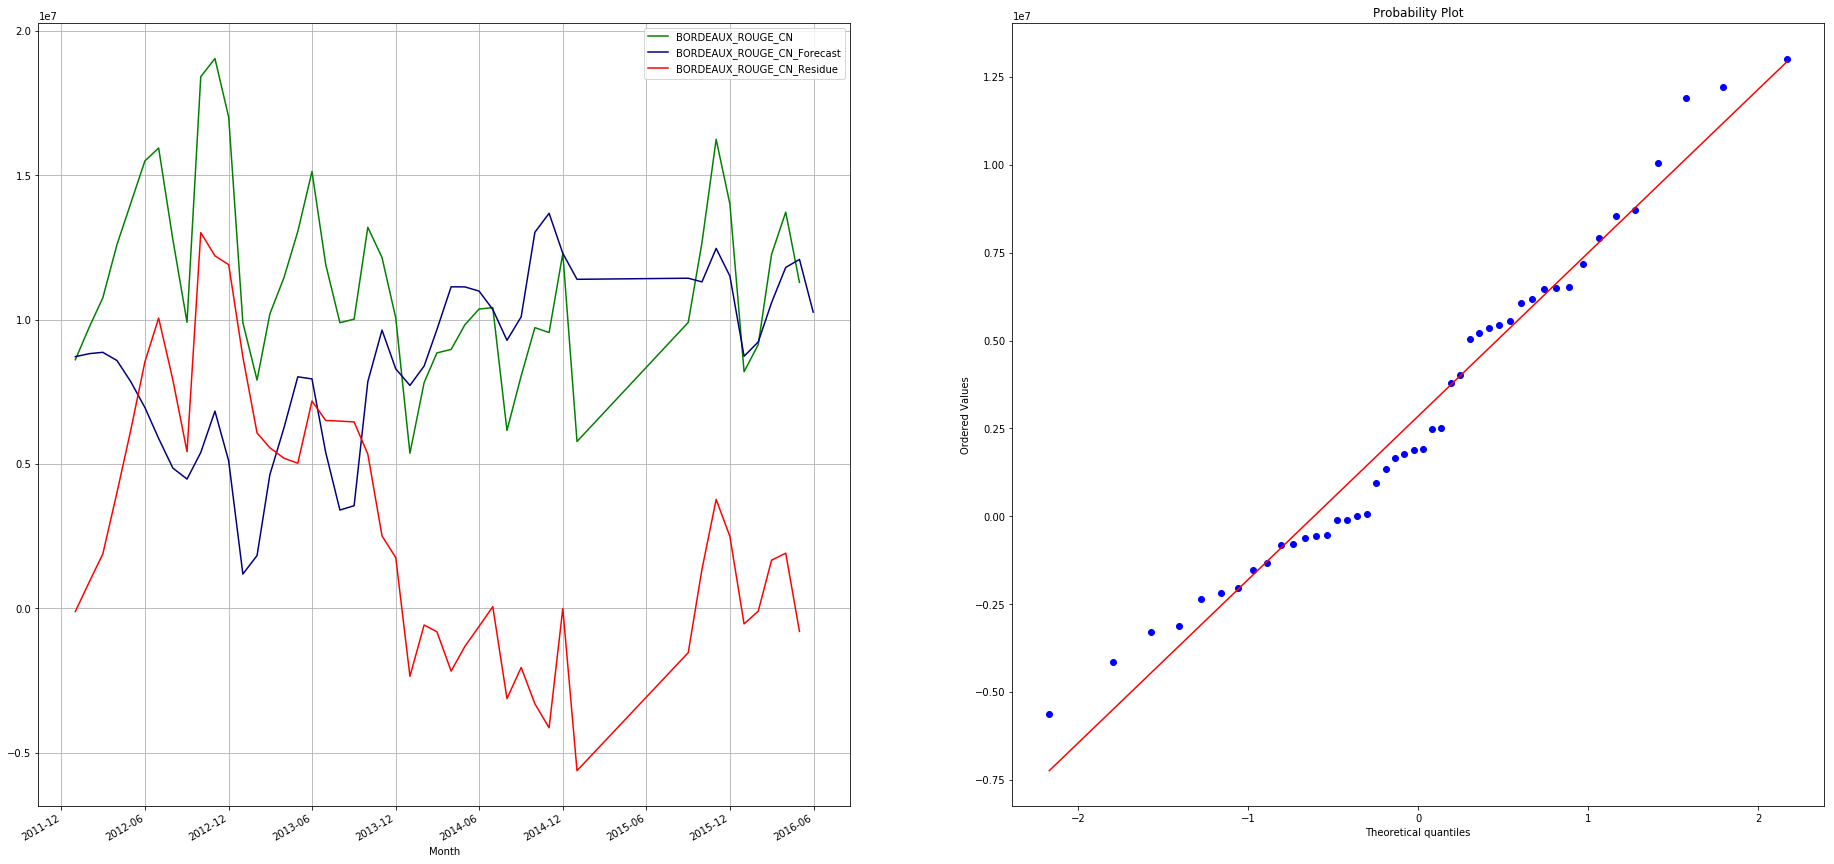

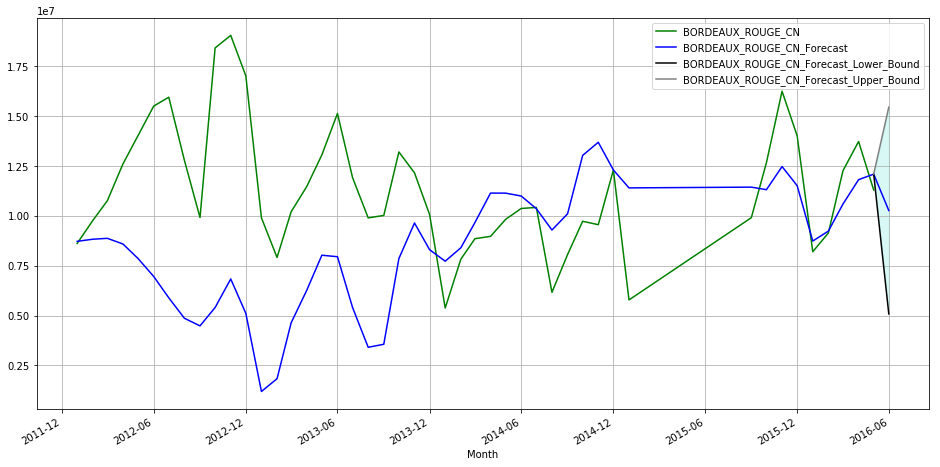

In [29]:
BORDEAUX_ROUGE_CN_Engine.standardPlots()

## Hierarchical Forecast Combinations


### Bottom-Up / Top-Down and Middle-Out Forecasts

In [30]:
lEngine.mOptions.mHierarchicalCombinationMethod = ["BU" , 'TD' , 'MO' , 'OC'];
dfapp_out = lEngine.forecast(train_df, H);


INFO:pyaf.std:START_HIERARCHICAL_FORECASTING
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.09624409675598145
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.13786864280700684
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.09963607788085938
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.09713506698608398
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.12817645072937012
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.10898685455322266
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.09757447242736816
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.0991201400756836
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.10086631774902344
INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 0.10643720626831055
INFO:p

/home/antoine/.local/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


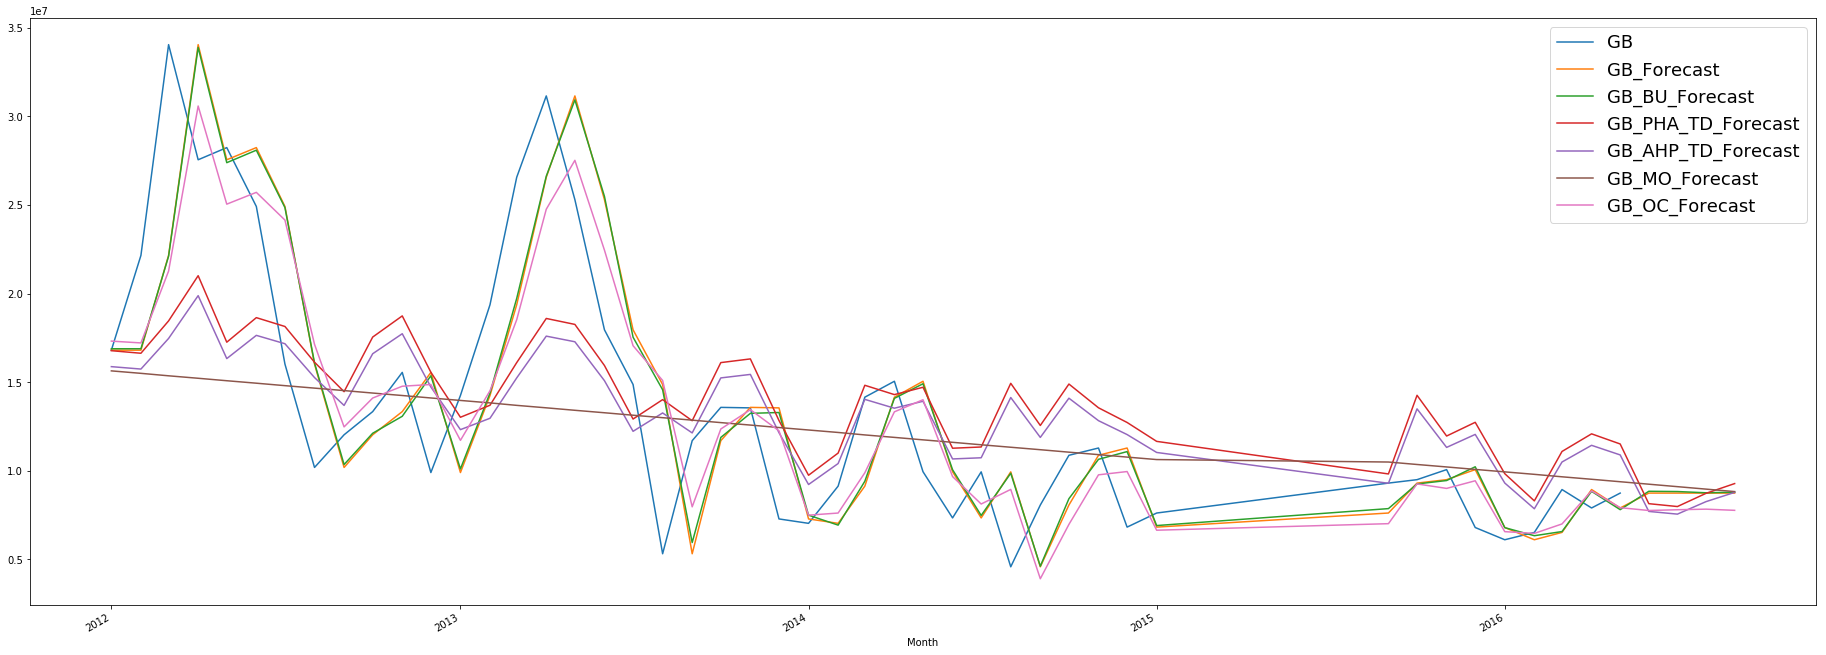

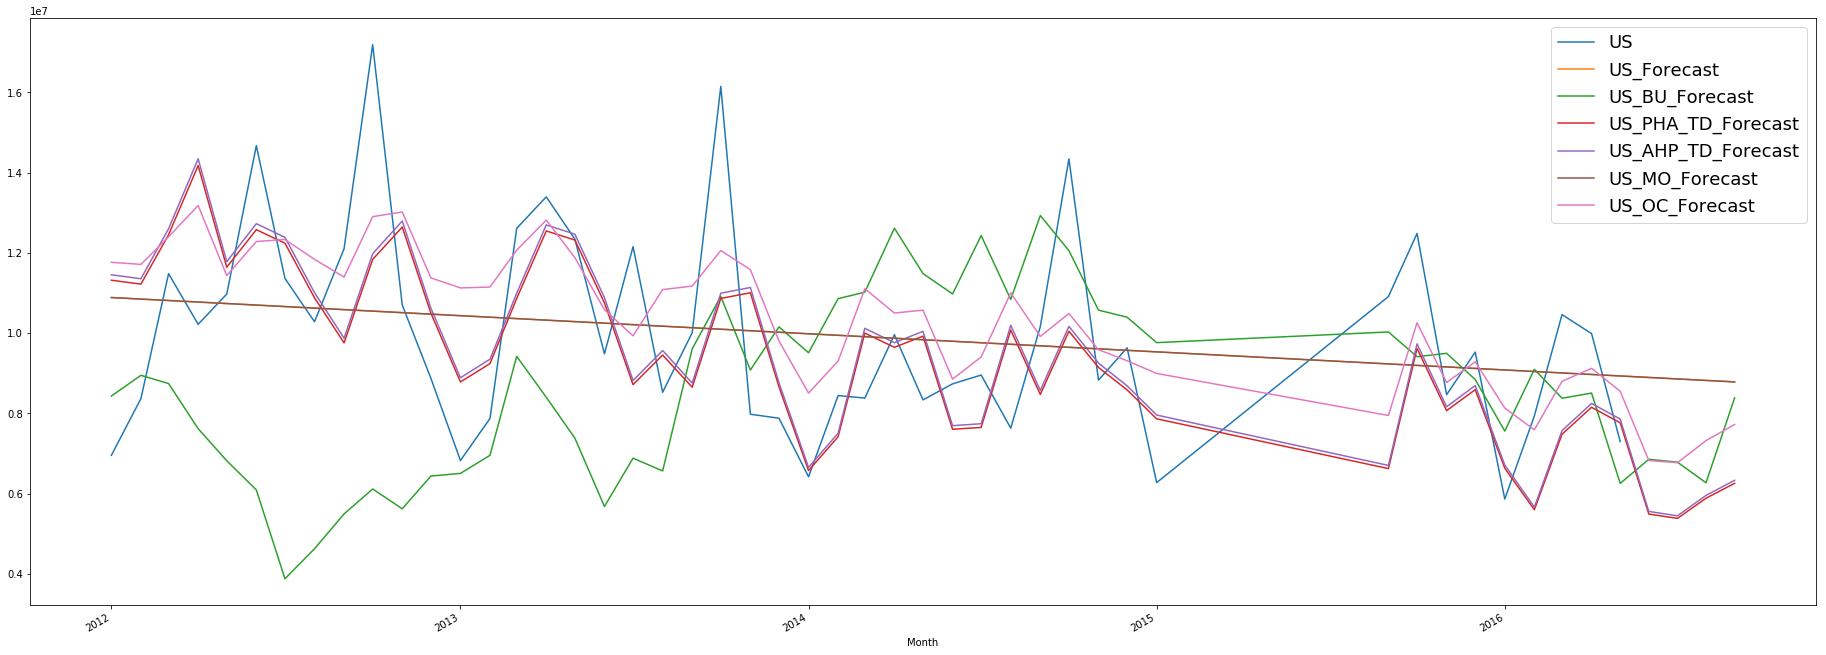

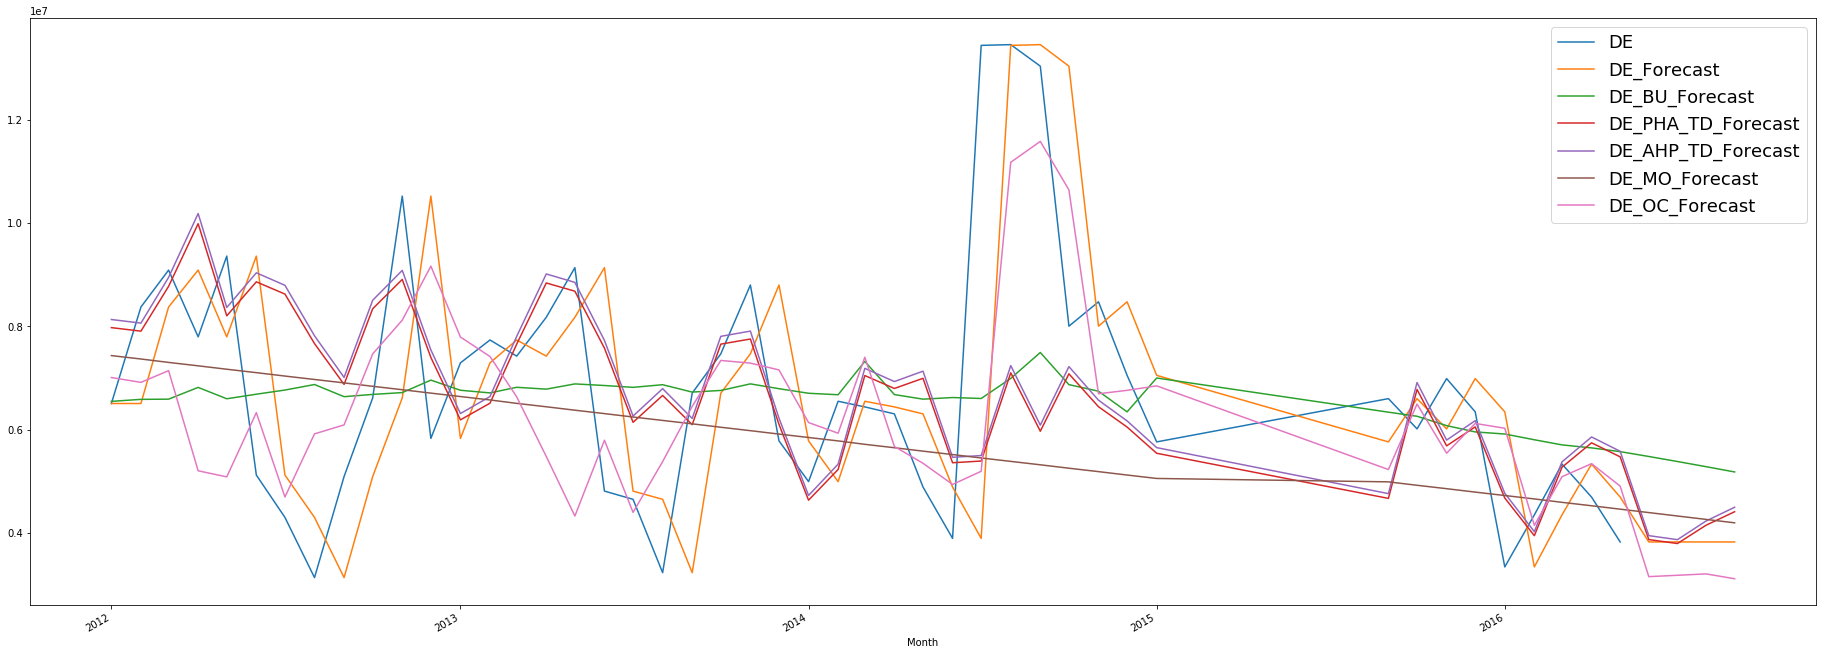

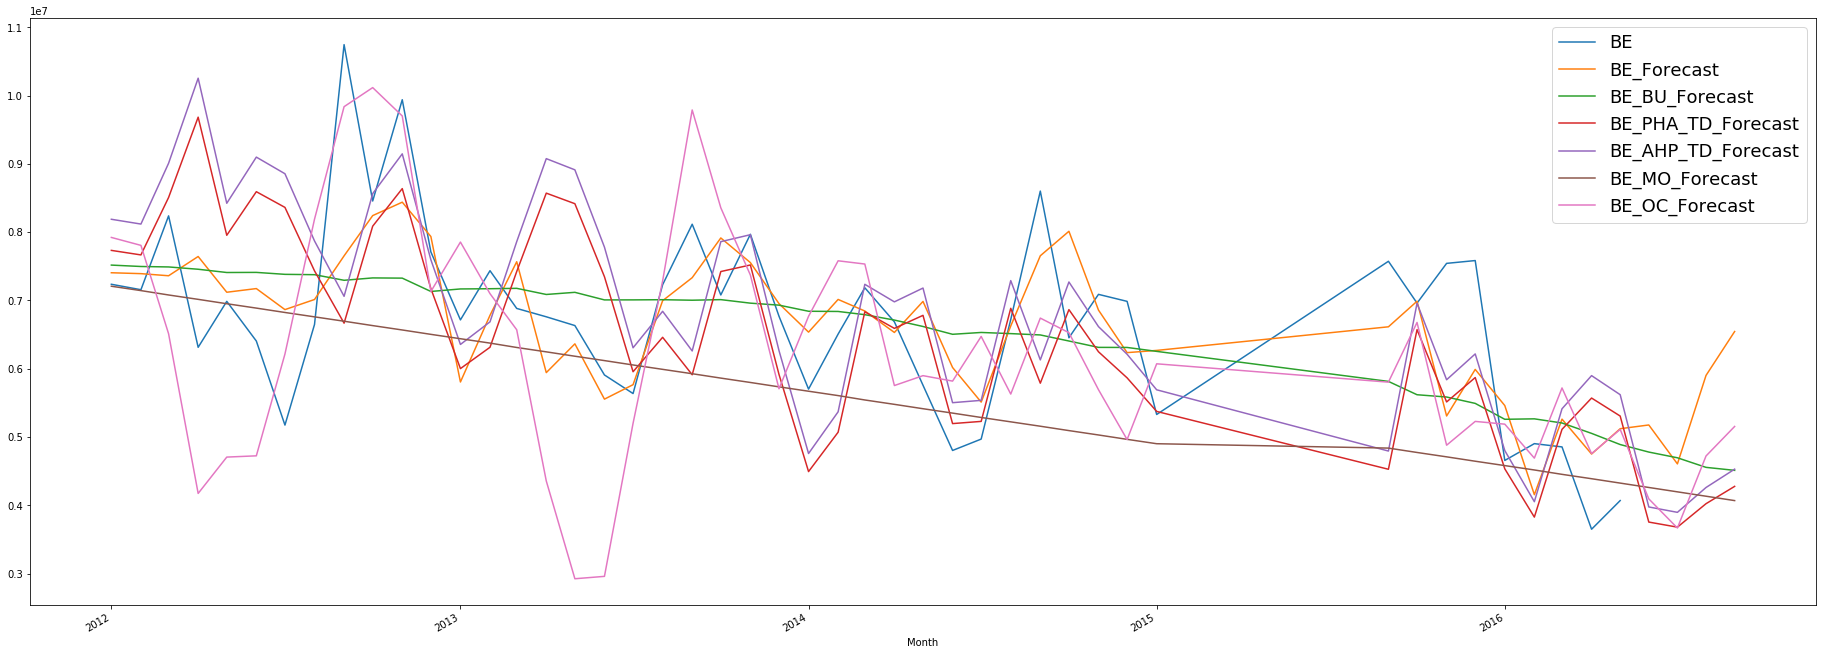

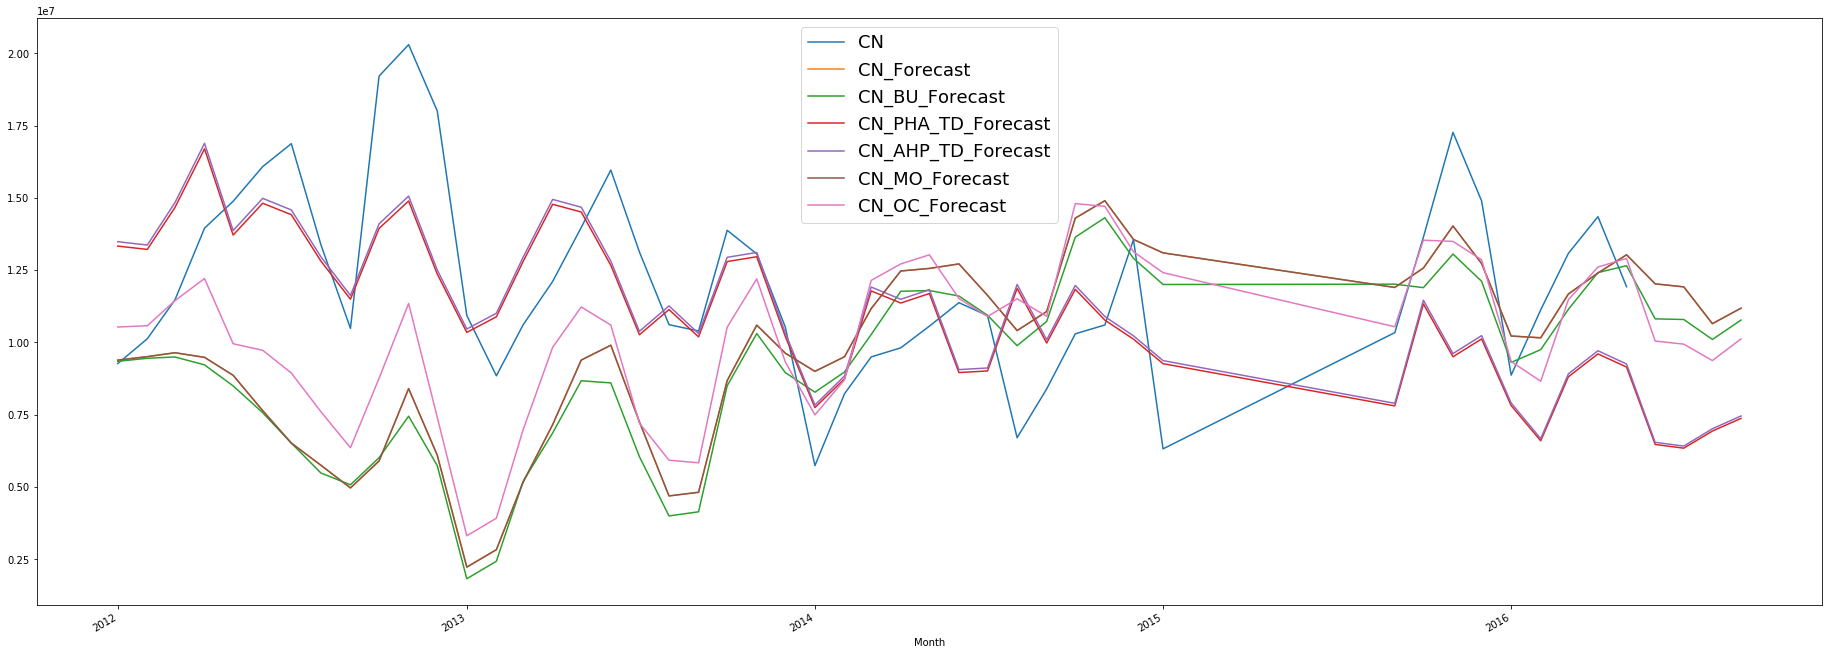

In [31]:
for country in Countries:
    dfapp_out.plot('Month' , 
                    [country , country + '_Forecast' , 
                     country + '_BU_Forecast',  
                     country + '_PHA_TD_Forecast',  
                     country + '_AHP_TD_Forecast'  ,  
                     country + '_MO_Forecast' ,
                     country + '_OC_Forecast'  ],
                figsize=(32 , 12)).legend(fontsize=18)

/home/antoine/.local/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


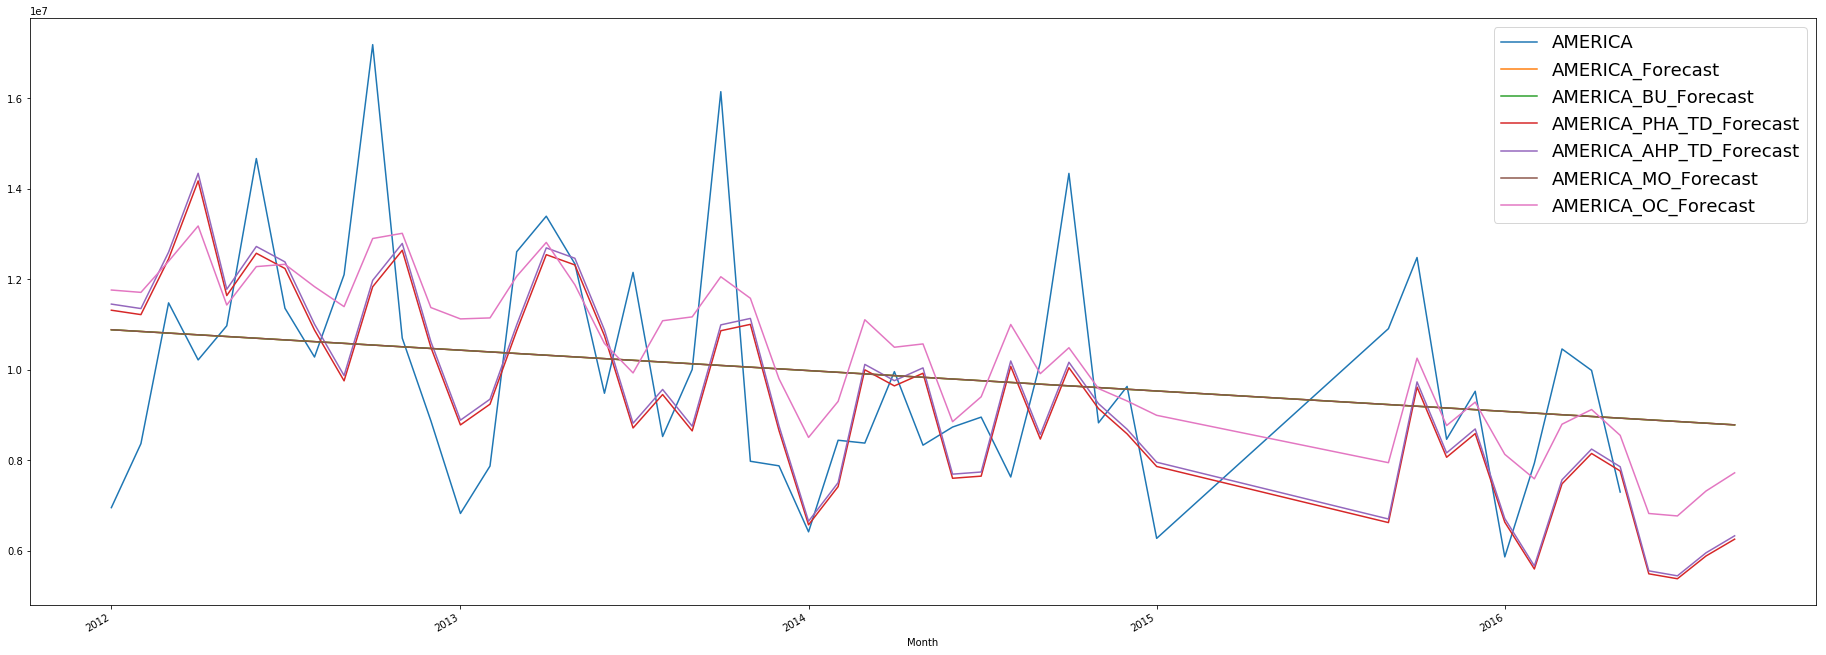

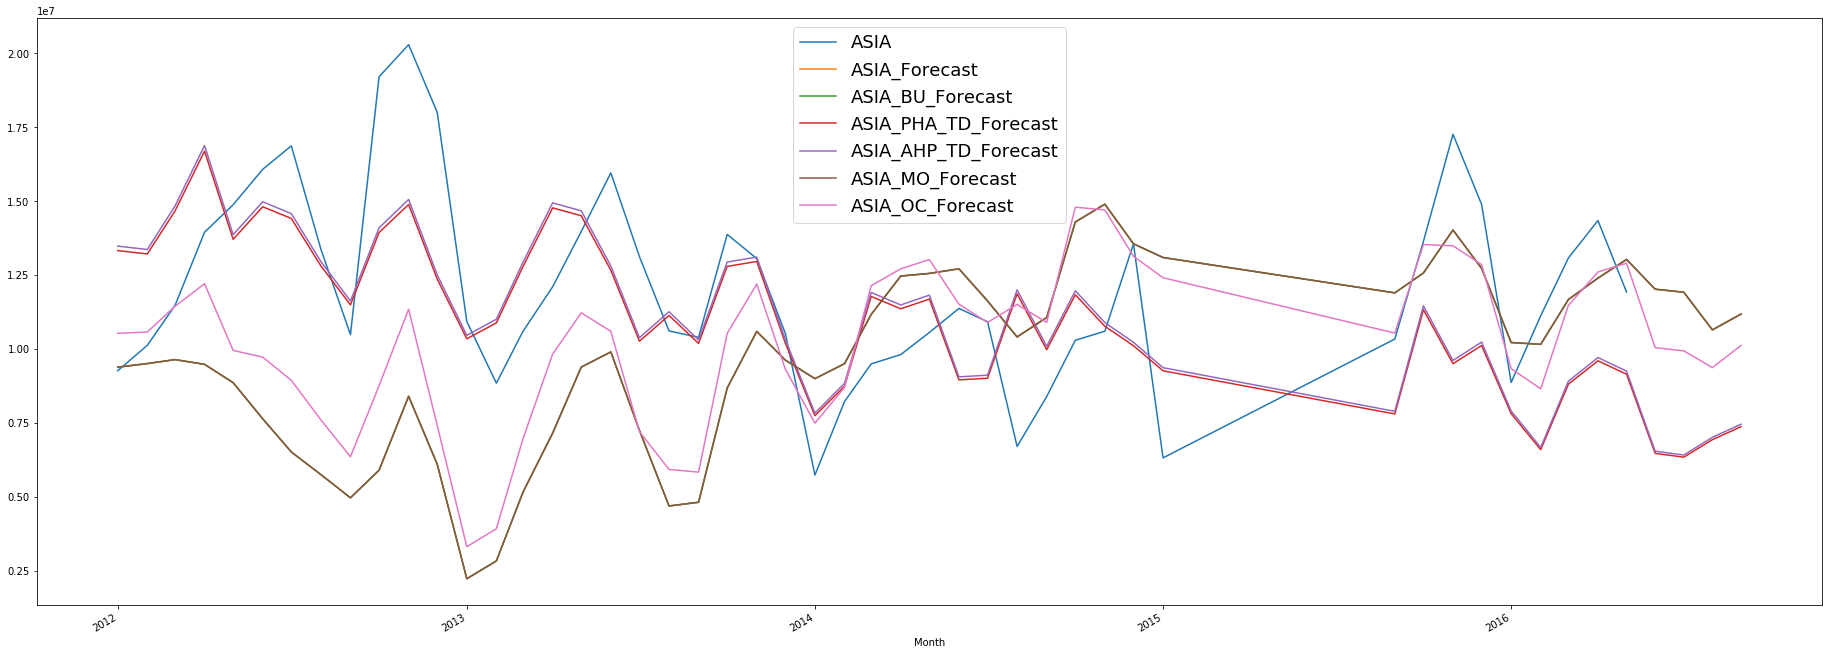

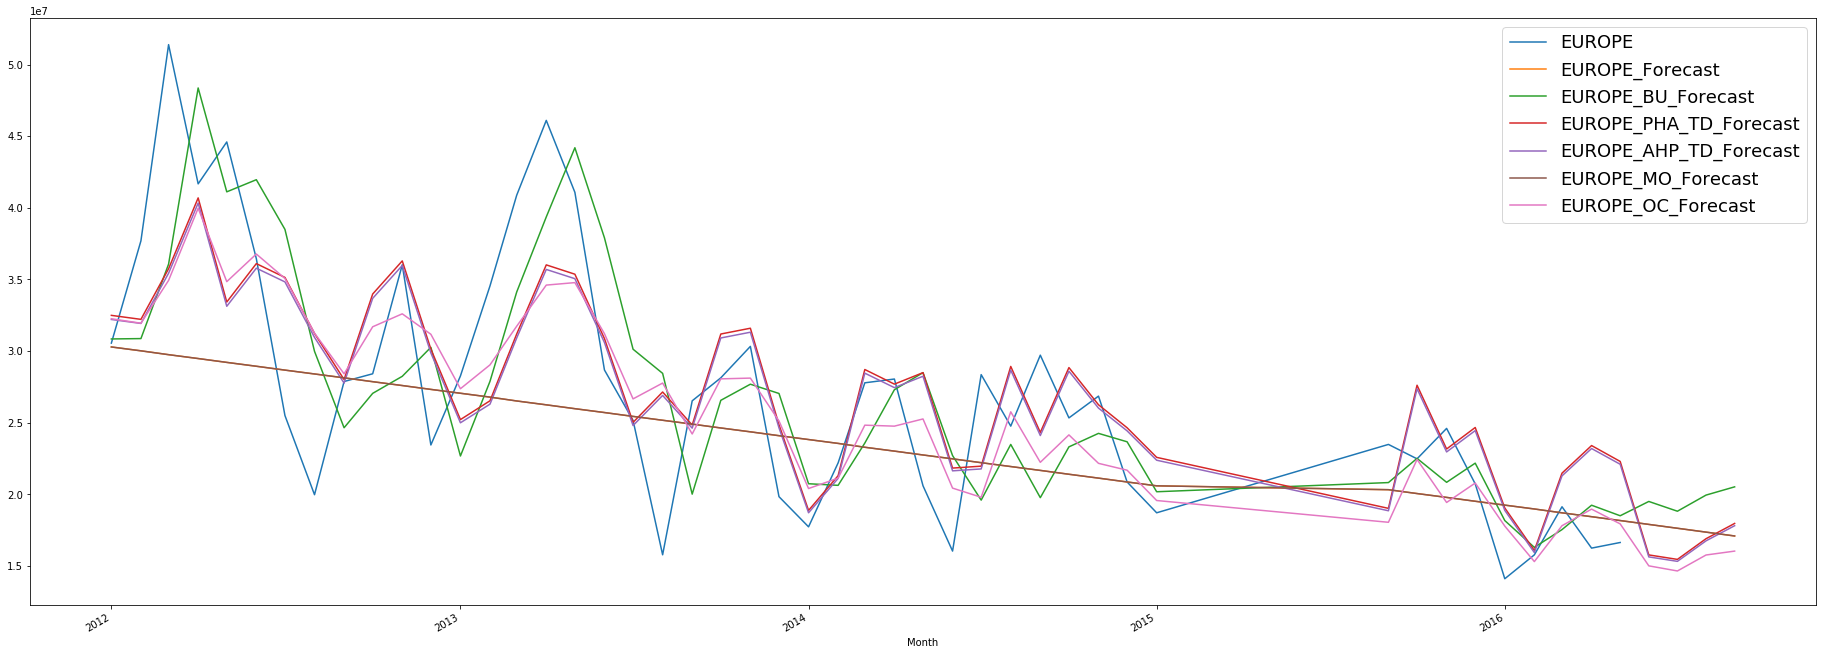

In [32]:
for region in ['AMERICA', 'ASIA', 'EUROPE']:
    dfapp_out.plot('Month' , 
                    [region , region + '_Forecast' , 
                     region + '_BU_Forecast',  
                     region + '_PHA_TD_Forecast',  
                     region + '_AHP_TD_Forecast'  ,  
                     region + '_MO_Forecast' ,
                     region + '_OC_Forecast'  ],
                    figsize=(32 , 12)).legend(fontsize=18)
 

/home/antoine/.local/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


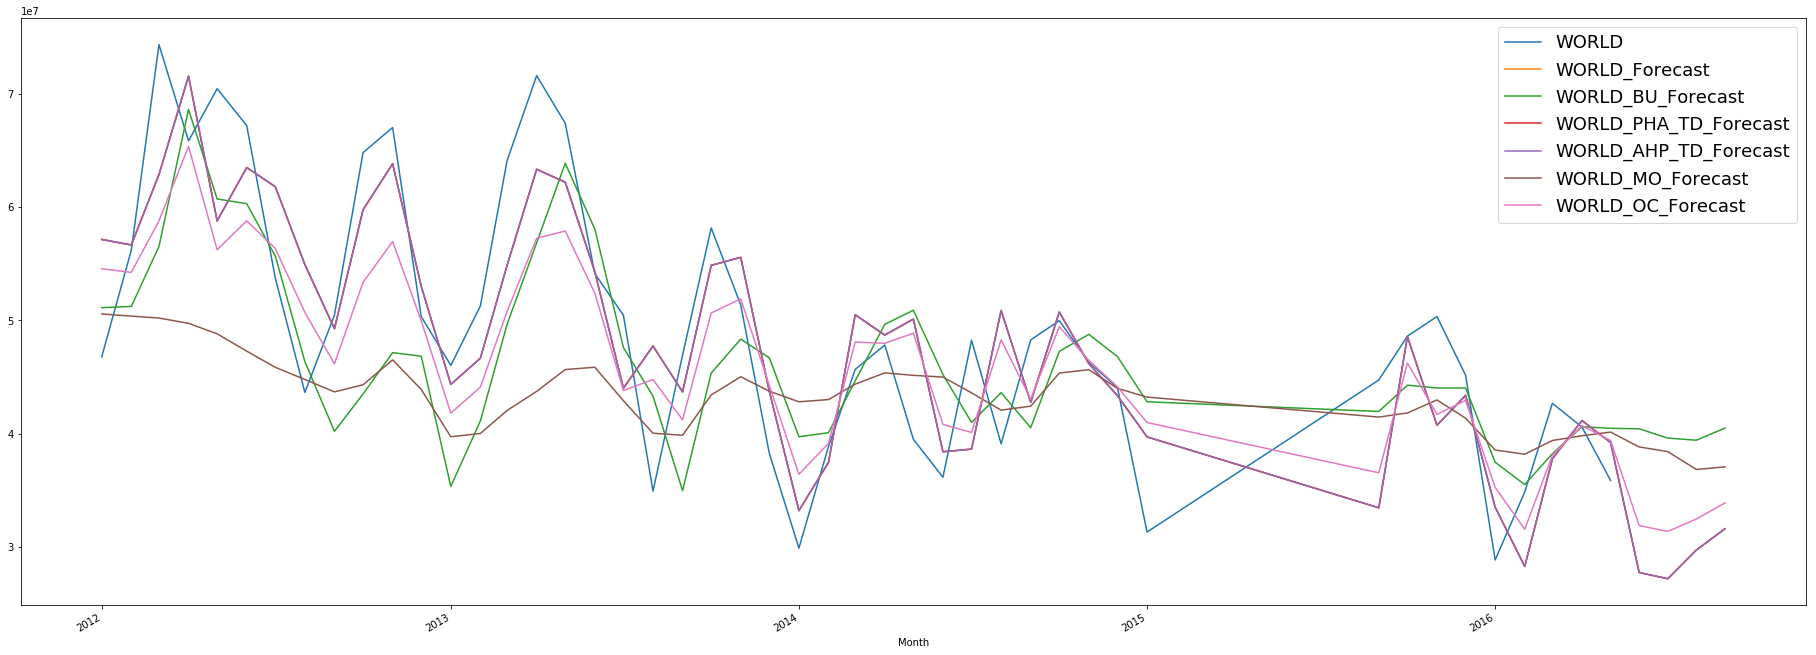

In [33]:
world = 'WORLD'
dfapp_out.plot('Month' , 
                [world , world + '_Forecast' , 
                 world + '_BU_Forecast',  
                 world + '_PHA_TD_Forecast',  
                 world + '_AHP_TD_Forecast'  ,  
                 world + '_MO_Forecast' ,
                 world + '_OC_Forecast'  ],
                figsize=(32 , 12)).legend(fontsize=18)